<a href="https://colab.research.google.com/github/marcochisci/Anomaly_detection/blob/main/1hour_AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airqino table Data
Average data values (every hour) of July, August, September, October and November to predict a three day period : the last three day of the selected data

In [ ]:
import pandas as pd
import psycopg2
import datetime
import pytz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline


conn = psycopg2.connect(host='playground.magentalab.it', port='45432', database='airqino', user='datareader', password='homntLZnlhQd9prtVA9SFezQek')

query=""" select time_bucket('1 hour', c."Dates" ) as "bucket", avg(c."O3") as "O3" ,  avg(c."PM2.5") as "PM2.5", avg(c."CO2") as "CO2",
 avg(c."Temp. int.") as "Temp. int.",  avg(c."T") as "T",  avg(c."PM10") as "PM10", avg(c."RH") as "RH", avg(c."NO2") as 
 "NO2", avg(c."CO") as "CO", avg(c."VOC") as "VOC"
from (select * from crosstab(
  'select sd.data_acquired as timestamp, s.sensor_type ,  sd.float_value as value 
from station_data sd join sensor s on s.id = sd.sensor_id
where sd.data_acquired >= to_timestamp(''2021-06-01 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
 and sd.data_acquired <= to_timestamp(''2021-12-09 23:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
and sd.station_id = 23284701 order by sd.data_acquired asc, 1'
 , $$VALUES ('O3'::varchar), ('PM2.5'::varchar), ('CO2'::varchar), ('Temp. int.'::varchar), ('T'::varchar)
 , ('PM10'::varchar), ('RH'::varchar), ('NO2'::varchar), ('CO'::varchar), ('VOC'::varchar)$$
) AS value ("Dates" timestamp, "O3" float, "PM2.5" float, "CO2" float, "Temp. int." float, "T" float, "PM10" float,
"RH" float, "NO2" float, "CO" float, "VOC" float))  c 
group by bucket
order by bucket asc;
 """
df = pd.read_sql(query, conn)
df= df.rename(columns={'bucket': 'Dates'})
df=df.set_index('Dates')
europe = pytz.timezone('Europe/Rome')
df.index = df.index.tz_localize(pytz.utc).tz_convert(europe)
#make the dates a string
df.reset_index(level=0, inplace=True)
df['Dates']= df['Dates'].astype(str)
for i in range(len(df)):
  df['Dates'][i]=datetime.datetime.strptime(df['Dates'][i], '%Y-%m-%d %H:%M:%S%z').strftime('%Y-%m-%d %H')
df=df.set_index('Dates')
## aggiungere solo se data presente
df=df.drop(['2021-10-31 02'], axis=0)

#fix temp int
df['Temp. int.'] = df['Temp. int.'].div(100)
df['T'] = df['T'].div(10)
df=df.dropna()

display(df)


/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-06-29 12,473.000000,2.000000,413.500000,40.512500,28.200000,9.500000,497.250000,302.250000,225.750000,363.500000
2021-06-29 13,455.043478,1.173913,409.956522,43.817391,29.895652,5.434783,387.956522,233.869565,215.043478,377.565217
2021-06-29 14,463.750000,1.200000,407.350000,44.951500,31.090000,5.700000,371.850000,210.900000,217.250000,382.850000
2021-06-29 15,484.451613,1.000000,409.419355,45.840968,31.825806,6.129032,356.774194,225.322581,217.000000,392.161290
2021-06-29 16,512.931034,1.000000,410.206897,46.758276,32.686207,6.448276,350.862069,246.000000,219.655172,406.137931
...,...,...,...,...,...,...,...,...,...,...
2021-12-09 19,207.575000,8.775000,444.600000,17.935000,5.425000,12.525000,825.300000,173.250000,188.525000,300.875000
2021-12-09 20,254.692308,5.435897,436.794872,17.259487,5.133333,7.564103,829.256410,102.820513,195.384615,287.307692
2021-12-09 21,230.410256,7.076923,441.487179,16.334872,4.346154,9.410256,893.076923,144.025641,187.102564,292.538462


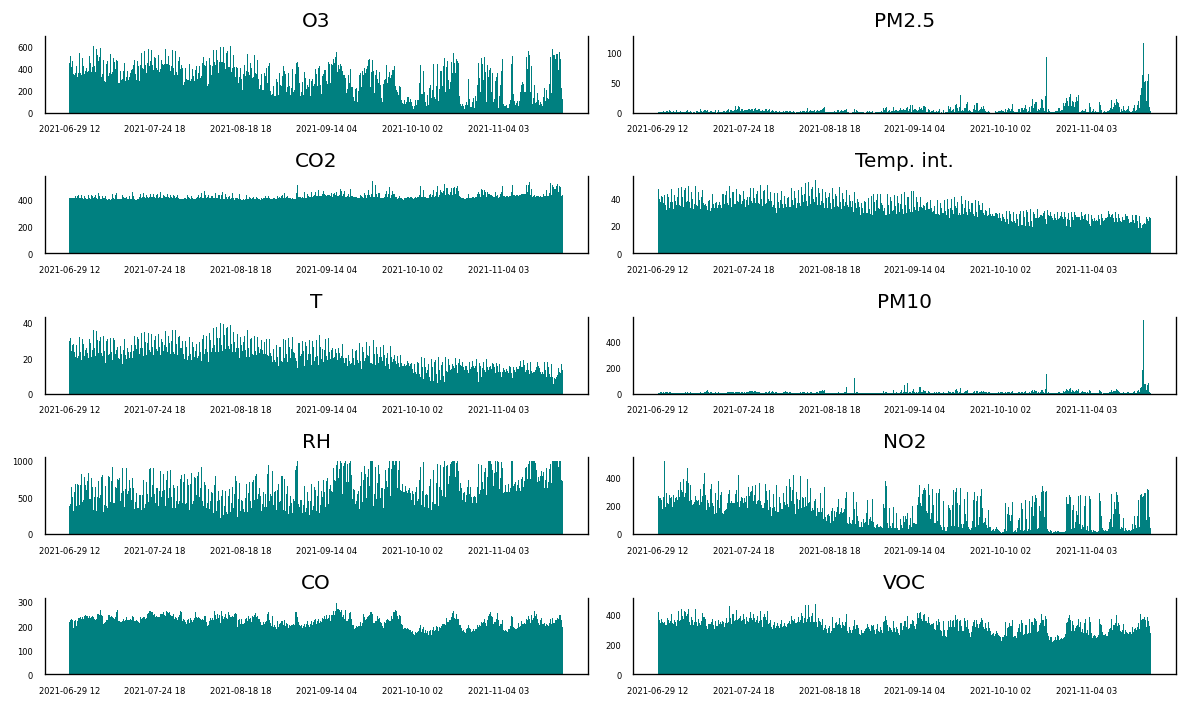

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
x_ticks = np.arange(0, len(df), 600)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.bar(data.index, data, color='teal', align='edge', width=1.0)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=5)
    ax.set_xticks(x_ticks)


plt.tight_layout();

# Wind data

Add the wind

,Wind
Date,
2021-06-29 12,1.725
2021-06-29 13,2.2
2021-06-29 14,2.075
2021-06-29 15,2.85
2021-06-29 16,3.2
...,...
2021-12-31 19,0.8
2021-12-31 20,0.7
2021-12-31 21,0.425


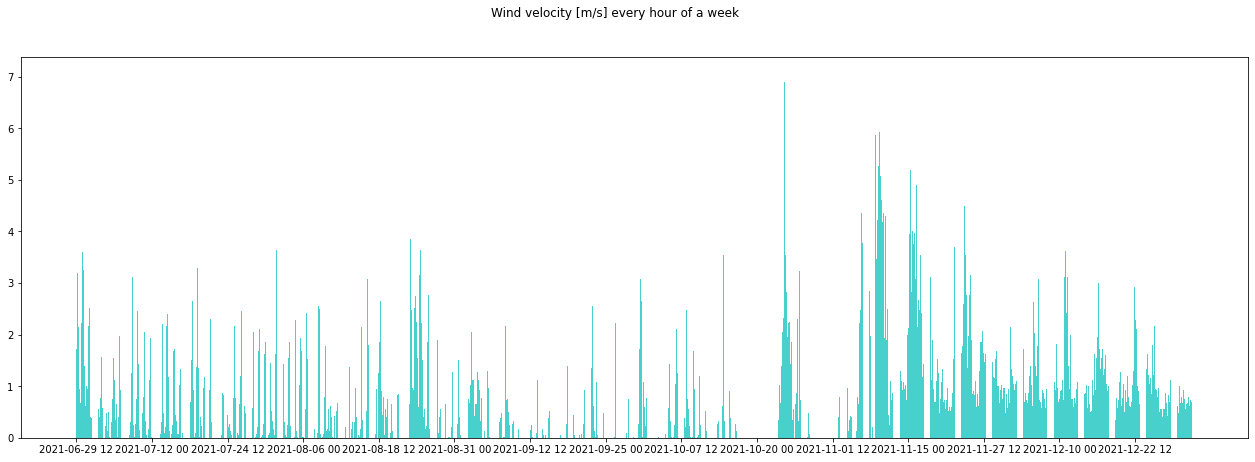

<Figure size 432x288 with 0 Axes>

In [ ]:
wind_temp = pd.read_csv('https://raw.githubusercontent.com/marcochisci/Anomaly_detection/main/anemo.csv')
wind_temp=wind_temp.set_index('Date')
wind_temp=wind_temp.loc['2021-06-29 12:00':'2022-01-01']
wind_temp.reset_index(level=0, inplace=True)
wind_temp=wind_temp.drop([' Potenza'], axis=1)
#ogni ora fa la media di 4 valori (ogni 15 minuti)
num_values=4
how_many=int(len(wind_temp)/num_values)
wind_df=pd.DataFrame(columns=wind_temp.columns)
for i in range(how_many):
  value=0
  for j in range(num_values):
    value=value+wind_temp[' Velocità [m/s]'][i*num_values+j]
  value=value/num_values
  wind_df.loc[i,:]=[wind_temp['Date'][i*num_values],value]
#cambia formato delle date
for i in range(len(wind_df)):
  wind_df['Date'][i]=datetime.datetime.strptime(wind_df['Date'][i], "%Y-%m-%d %H:%M").strftime('%Y-%m-%d %H')
wind_df=wind_df.set_index('Date')
wind_df= wind_df.rename(columns={' Velocità [m/s]': 'Wind'})
display(wind_df)

# Plot
data_wind=wind_df['Wind']
plt.figure(figsize=(22, 7))
plt.bar(wind_df.index, data_wind, color='mediumturquoise', align='edge',linewidth=1)
# Decorations
x_ticks = np.arange(0, len(wind_df), 300)
plt.xticks(x_ticks)
plt.suptitle('Wind velocity [m/s] every hour of a week')
plt.show()

plt.tight_layout();


Join the dataframes together, only get the rows that have all the values

In [ ]:
df=df.join(wind_df, how='outer')
df=df.dropna()
display(df)


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-06-29 12,473.000000,2.000000,413.500000,40.512500,28.200000,9.500000,497.250000,302.250000,225.750000,363.500000,1.725
2021-06-29 13,455.043478,1.173913,409.956522,43.817391,29.895652,5.434783,387.956522,233.869565,215.043478,377.565217,2.2
2021-06-29 14,463.750000,1.200000,407.350000,44.951500,31.090000,5.700000,371.850000,210.900000,217.250000,382.850000,2.075
2021-06-29 15,484.451613,1.000000,409.419355,45.840968,31.825806,6.129032,356.774194,225.322581,217.000000,392.161290,2.85
2021-06-29 16,512.931034,1.000000,410.206897,46.758276,32.686207,6.448276,350.862069,246.000000,219.655172,406.137931,3.2
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-22 19,124.897436,3.307692,429.974359,25.146154,13.600000,4.205128,732.153846,51.820513,197.666667,280.282051,2.875
2021-11-22 20,126.100000,3.050000,429.225000,25.149500,13.422500,4.175000,729.925000,47.775000,197.575000,279.200000,2.95
2021-11-22 21,107.128205,2.769231,425.282051,25.530256,13.779487,3.487179,722.948718,38.205128,197.589744,272.282051,2.25
2021-11-22 22,101.600000,1.975000,424.100000,25.623000,13.897500,2.275000,728.350000,36.375000,196.700000,268.050000,2.675


# Preparations

In [ ]:
df_copy= df.copy()

In [ ]:
pip install fitter

# VAR model mahalanobis

Testing stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df, col)
    for col in df.columns
}
adf_test_results     

{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Converting to stationary with differencing.
Use the differencing on all the variables for the malahanobis distance

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df.columns:
    df[col] = differencing(df, col, 1)

Test for stationarity now

Finding the best lag for VAR model (if the max_lag value is too high the model may not work)

In [ ]:
from statsmodels.tsa.api import VAR
max_lag = 40
var_model = VAR(df)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(selected_lag)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


25


Calculating the errors

In [ ]:
import numpy as np
import scipy as sp

#mahalanobis distance
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()
var = VAR(df)
var_fitresults = var.fit(selected_lag)
var_summarymaha=str(var_fitresults.summary())
print(var_summarymaha[0:624])
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[selected_lag:], columns=df.columns)
errors = mahalanobis(x=var_fit_df, data= df)
errors_df=pd.DataFrame(errors, index=df_copy.index[selected_lag:], columns={"errors"})

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Feb, 2022
Time:                     18:18:44
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    37.4330
Nobs:                     3836.00    HQIC:                   34.7953
Log likelihood:          -115870.    FPE:                3.02739e+14
AIC:                      33.3420    Det(Omega_mle):     1.60623e+14
--------------------------------------------------------------------



In [ ]:
display(var_fit_df)

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-06-30 13,22.206075,0.994389,-1.017665,1.642646,1.187779,2.507877,-25.913218,-5.208503,1.205674,11.497213
2021-06-30 14,14.377110,0.909696,1.392364,0.223739,0.277644,4.785808,9.735212,-0.369273,2.573106,8.949837
2021-06-30 15,-8.159534,-0.084562,-2.201483,0.237479,0.302172,0.330663,-1.119702,-6.960200,-0.711603,0.347319
2021-06-30 16,3.249651,1.289755,0.383232,0.498425,0.388625,3.342774,-15.004513,4.612918,-0.440164,6.432663
2021-06-30 17,-11.433434,-0.625288,-1.978620,-0.086635,-0.133902,0.849229,-8.939611,2.767612,-2.016344,1.754804
...,...,...,...,...,...,...,...,...,...,...
2021-12-09 19,59.229901,9.899788,16.003666,-0.577835,-1.008346,18.969694,64.528142,111.823035,2.234363,25.709297
2021-12-09 20,43.725428,0.292490,-7.313694,0.115213,0.230734,-0.923398,-1.840121,-57.457727,5.001629,-7.282148
2021-12-09 21,-28.797596,6.503685,4.968443,-0.621808,-0.898555,-5.090608,37.303729,12.488716,-1.351134,-1.452792


# Testing the mahalanobis errors' distribution and finding the thresholds

Make a histogram

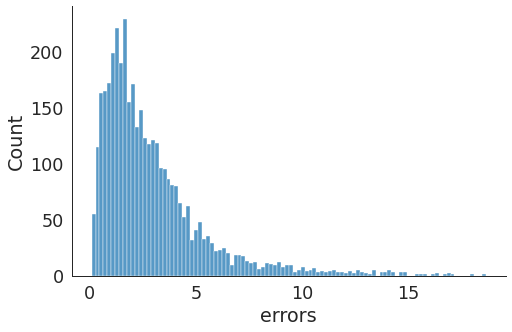

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats
#remove outliers
z_scores = stats.zscore(errors_df)

abs_z_scores = np.abs(z_scores)
filtered_errors = (abs_z_scores < 3).all(axis=1)
new_errors_df = errors_df[filtered_errors]

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=new_errors_df, x="errors", kind="hist", bins = 100, aspect = 1.5)

Find the best distribution (the output ranks the best distributions in ascending order)

          sumsquare_error         aic           bic  kl_div
lognorm          0.013221  893.417923 -47912.839718     inf
invgauss         0.013718  902.467087 -47772.001789     inf
pearson3         0.019917  967.823461 -46350.292186     inf
gamma            0.019918  967.824093 -46350.143907     inf
beta             0.021823  958.115494 -45993.644286     inf


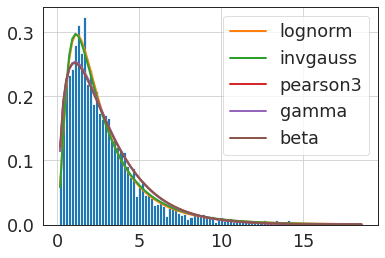

In [ ]:
er = new_errors_df["errors"].values
er_min=min(er)
er_max=max(er)
f = Fitter(er,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param=f.fitted_param[distribution]

In [ ]:
def get_num_var(distribution):
  if(distribution=='burr' or distribution=='beta'):
    num_var=2
  if(distribution=='invgauss' or distribution=='gamma' or distribution=='weibull_min' or distribution=='weibull_max' or distribution=='lognorm'
         or distribution=='pearson3' or distribution=='triang' ):
    num_var=1
  if(distribution=='expon' or distribution=='norm' or distribution=='uniform' ):
    num_var=0
  return num_var

In [ ]:
from scipy.stats import burr, beta, expon, norm, uniform, weibull_min, weibull_max, invgauss, gamma, lognorm, pearson3, triang

#distributions, convert from string to dis
distributions={"burr": burr, "beta": beta, "invgauss": invgauss, "gamma": gamma, "weibull_min": weibull_min, "weibull_max": weibull_max,
               "lognorm": lognorm, "pearson3": pearson3, "triang": triang, "expon": expon, "norm": norm, "uniform": uniform}

threshold low: 10.061571569952843
threshold med: 13.263216022931445
threshold high: 16.018119389447914


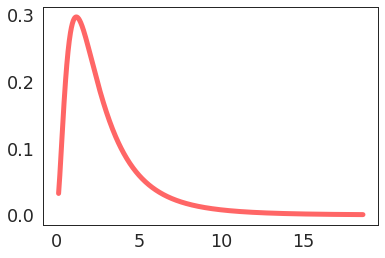

In [ ]:
from scipy.stats import invgauss
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

low, med, high= 0.975, 0.99, 0.995
find= np.linspace(er_min+((er_max-er_min)/1000),er_max*2, 2000)
x = np.linspace(er_min+((er_max-er_min)/1000),er_max, 1000)
dis=distributions[distribution]
num_var=get_num_var(distribution)
if(num_var==0):
    loc, scale = param[0], param[1]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i, loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
#1 variables
if(num_var==1):
  c= param[0]
  loc, scale = param[1], param[2]
  #graph to test if the parameters are correct
  ax.plot(x, dis.pdf(x,c, loc, scale),
       'r-', lw=5, alpha=0.6)
  # using the cdf
  found=0
  for i in find:
    if ((dis.cdf(i, c,loc, scale)>low) & (found<1)):        
      threshold_l=i
      found=1
    if ((dis.cdf(i,c, loc, scale)>med) & (found<2)):
      threshold_m=i
      found=2
    if ((dis.cdf(i,c, loc, scale)>high) & (found<3)):
      threshold_h=i
      found=3
#3 variables
if(num_var==2):
  c,d= param[0], param[1]
  loc, scale = param[2], param[3]
  #graph to test if the parameters are correct
  ax.plot(x, dis.pdf(x,c,d, loc, scale),
       'r-', lw=5, alpha=0.6)

  # using the cdf
  found=0
  for i in find:
    if ((dis.cdf(i,c,d, loc, scale)>low) & (found<1)):
      threshold_l=i
      found=1
    if ((dis.cdf(i,c,d, loc, scale)>med) & (found<2)):
      threshold_m=i
      found=2
    if ((dis.cdf(i,c,d, loc, scale)>high) & (found<3)):
      threshold_h=i
      found=3
print('threshold low: '+str(threshold_l))
print('threshold med: '+str(threshold_m))
print('threshold high: '+str(threshold_h))

# Finding anomalies with mahalanobis distance

In [ ]:
#0 means that is it not an anomaly
def find_anomalies(errors, threshold_low, threshold_med, threshold_high):
  predictions=pd.DataFrame(np.zeros((len(errors), 1)))
  for i in range(len(errors)):
    if((errors.iloc[i].values >= threshold_low) &(errors.iloc[i].values < threshold_med)):
      predictions.iloc[i]=1
    if((errors.iloc[i].values >= threshold_med) &(errors.iloc[i].values < threshold_high)):
      predictions.iloc[i]=2
    if(errors.iloc[i].values >= threshold_high):
      predictions.iloc[i]=3
  return predictions

predictions = find_anomalies(abs(errors_df),threshold_l, threshold_m, threshold_h)

Select how many values do you want to predict: there are 24 values each day.

If you want to find the anomalies of the period between the 13th and the 15th of November hom_many should be set at 72

In [ ]:
data = df_copy.iloc[selected_lag: , :]
data['Predictions'] = predictions.values
how_many=72
data=data.iloc[-how_many:,:]
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-12-07 00,549.150000,29.275000,476.000000,12.094750,0.277500,42.375000,883.100000,256.600000,204.950000,375.025000,0.0
2021-12-07 01,511.605263,20.236842,462.473684,11.529474,0.184211,29.736842,913.894737,236.973684,206.842105,359.973684,0.0
2021-12-07 02,459.388889,14.444444,451.083333,11.007500,0.241667,20.916667,917.361111,221.444444,197.000000,333.611111,0.0
2021-12-07 03,493.974359,27.102564,462.512821,10.695128,0.989744,34.871795,962.256410,238.512821,196.743590,336.769231,0.0
2021-12-07 04,488.500000,25.325000,464.900000,10.643250,1.125000,32.225000,979.100000,237.325000,201.600000,341.450000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-09 19,207.575000,8.775000,444.600000,17.935000,5.425000,12.525000,825.300000,173.250000,188.525000,300.875000,2.0
2021-12-09 20,254.692308,5.435897,436.794872,17.259487,5.133333,7.564103,829.256410,102.820513,195.384615,287.307692,2.0
2021-12-09 21,230.410256,7.076923,441.487179,16.334872,4.346154,9.410256,893.076923,144.025641,187.102564,292.538462,1.0


In [ ]:
data['Predictions'].value_counts()

0.0    53
3.0     8
2.0     7
1.0     4
Name: Predictions, dtype: int64

# Showing the anomalies found with Mahalanobis distance with graphs, differenced values

get all the anomalies

In [ ]:
anomalies_l= df.iloc[-how_many:][(data['Predictions'] == 1)]
anomalies_m= df.iloc[-how_many:][(data['Predictions'] == 2)]
anomalies_h= df.iloc[-how_many:][(data['Predictions'] == 3)]

Get the days before to compare

In [ ]:
day_before= df.iloc[-(how_many*2):-how_many,:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError

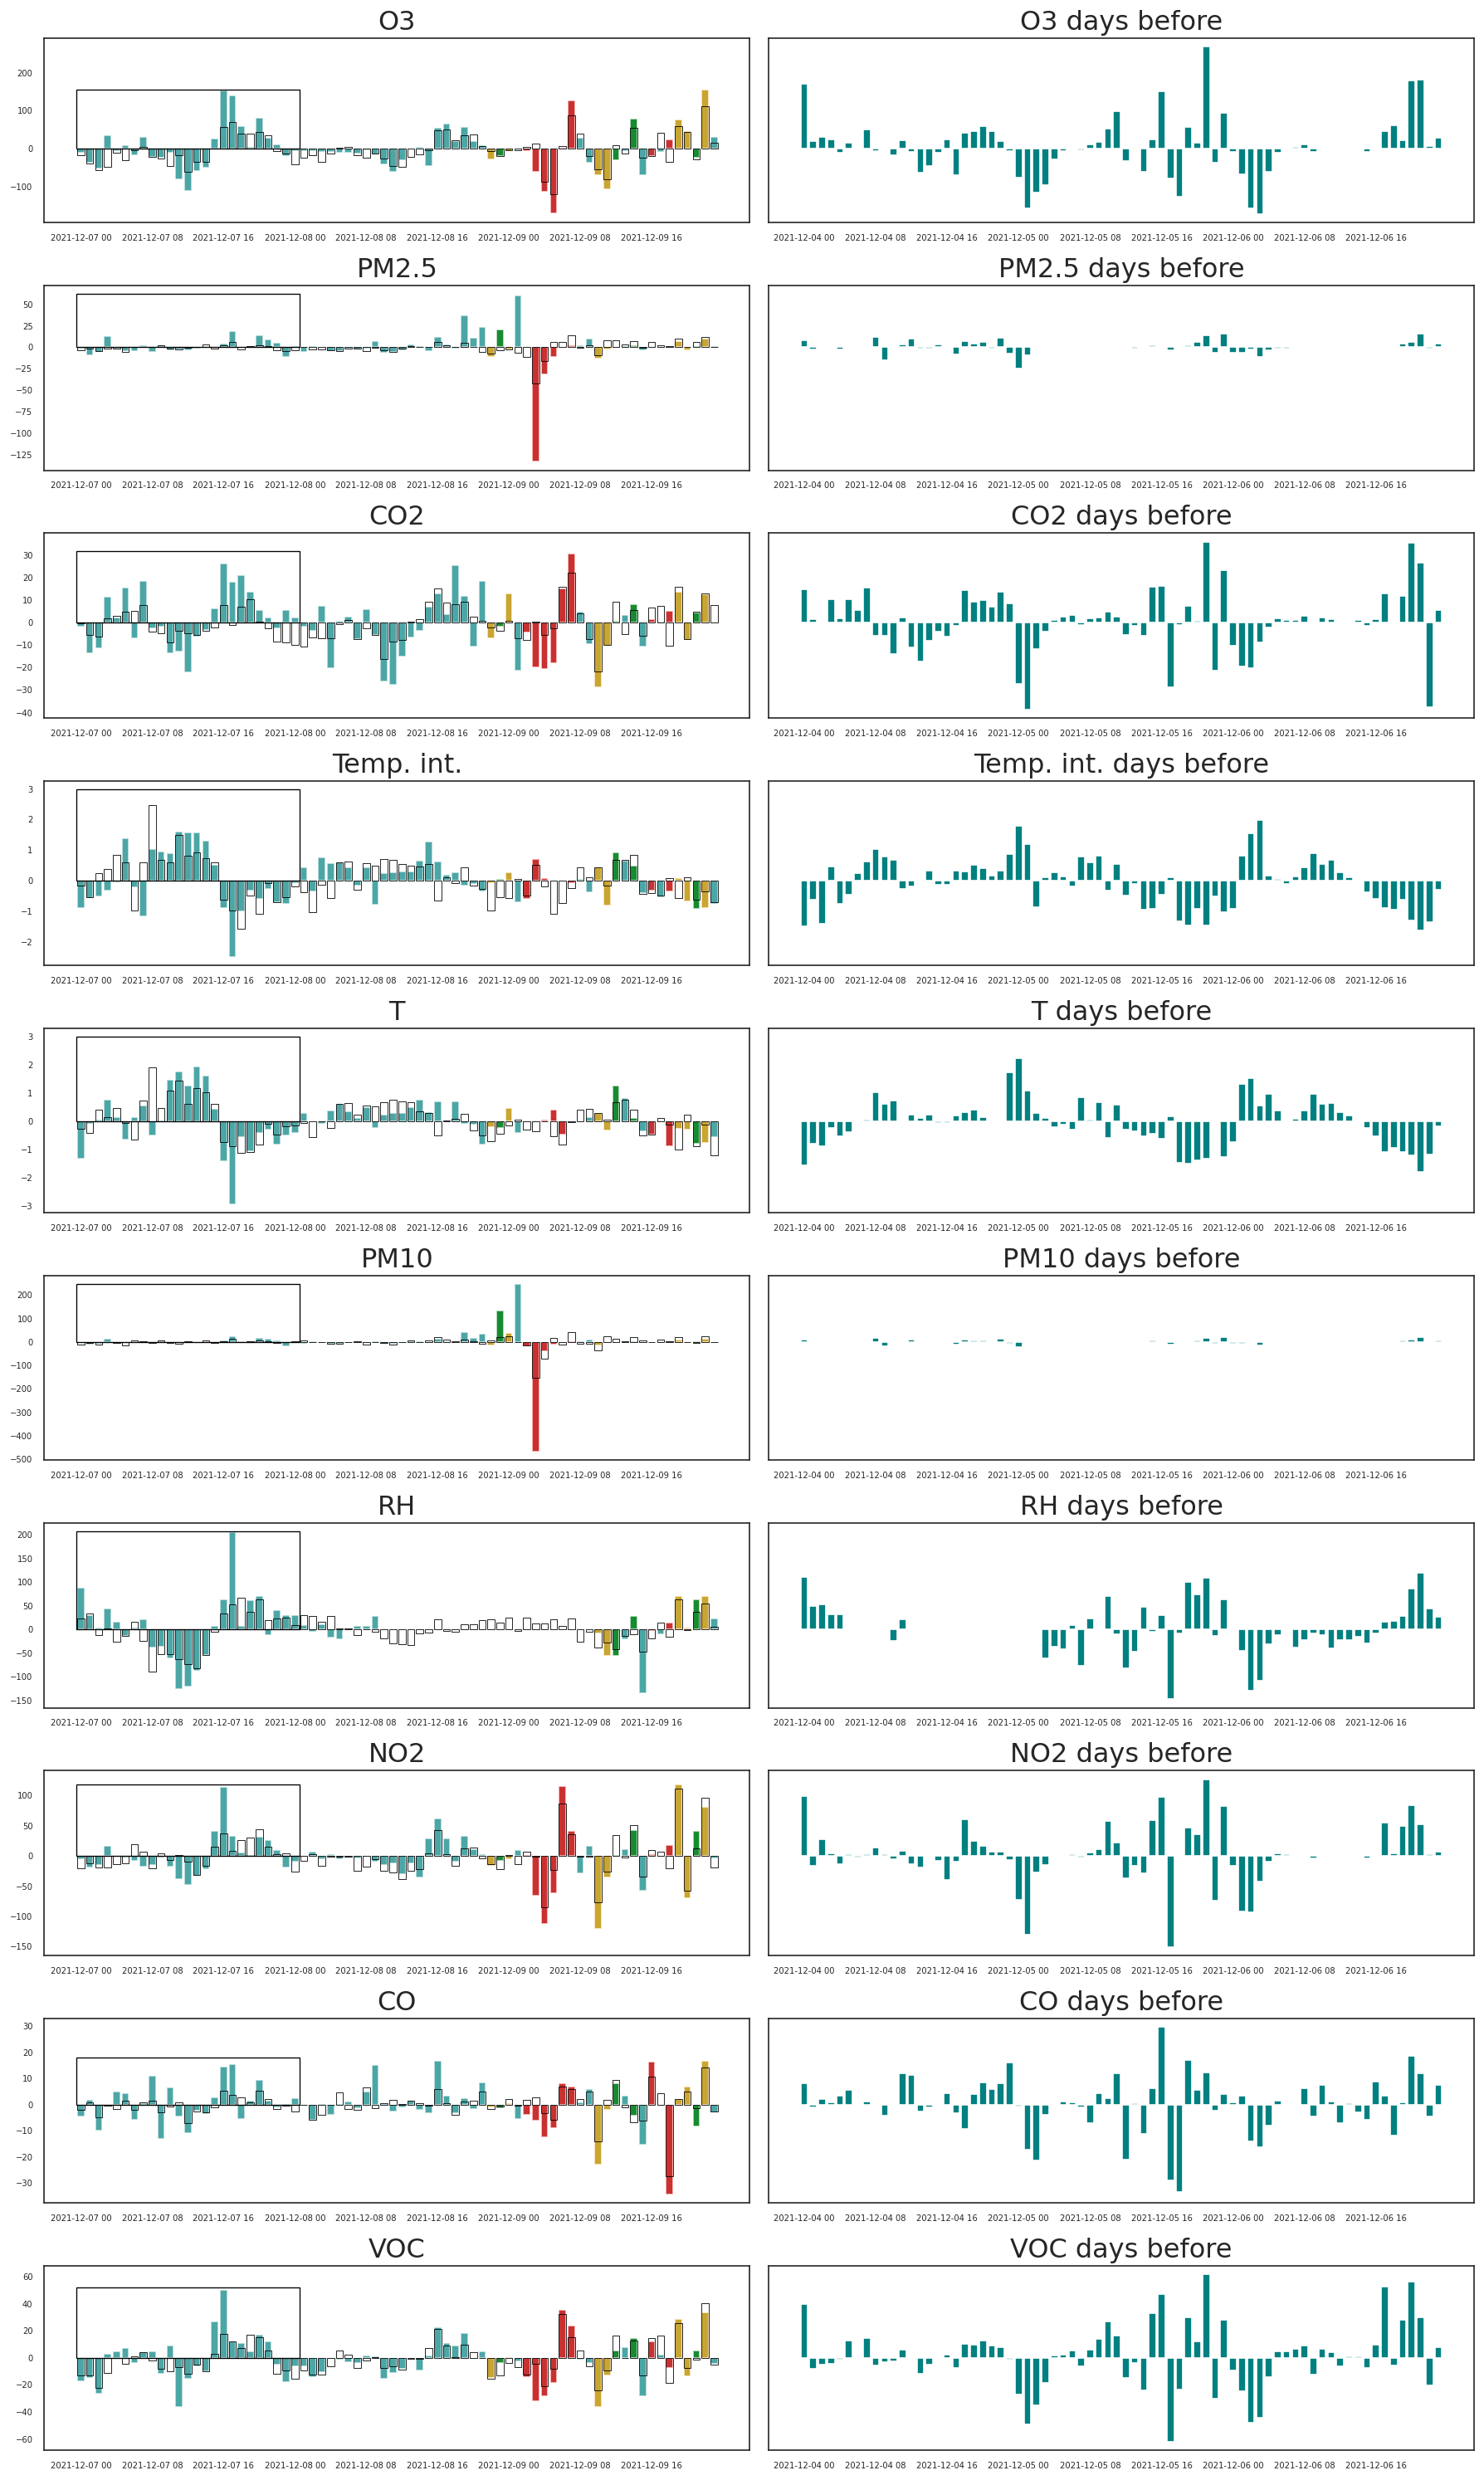

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib
%matplotlib inline

num_col=len(df_copy.columns)
# Plot
fig, axes = plt.subplots(nrows=num_col, ncols=2, sharey='row', dpi=120, figsize=(15,25))
x_ticks = np.arange(0, how_many, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_maha = df.iloc[-how_many:][df.columns[i/2]]
      ax.bar(data_maha.index, data_maha, color='teal', alpha=0.7, linewidth=1)
      ax.set_xticks(x_ticks)
      
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', alpha=0.7,  linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange',alpha=0.7,  linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red',alpha=0.7, linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag, int(max(df.iloc[-how_many:][df.columns[i/2]])+2))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))
      data_expeted= var_fit_df.iloc[-how_many:][df.columns[i/2]]
      ax.bar(data_expeted.index, data_expeted ,fill = False, edgecolor = 'black', linewidth=0.5)

      # Decorations
      ax.set_title(df.columns[i/2])
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before[df.columns[(i-1)/2]]
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      # Decorations
      ax.set_title(df.columns[(i-1)/2]+' days before')
      ax.tick_params(labelsize=6)
      ax.set_xticks(x_ticks)

plt.tight_layout();


# Showing the anomalies found with Mahalanobis distance with graphs

get all the anomalies

In [ ]:
anomalies_l= data[(data['Predictions'] == 1)]
anomalies_m= data[(data['Predictions'] == 2)]
anomalies_h= data[(data['Predictions'] == 3)]

Get the days before to compare

In [ ]:
day_before= df_copy.iloc[-(how_many*2):-how_many,:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError

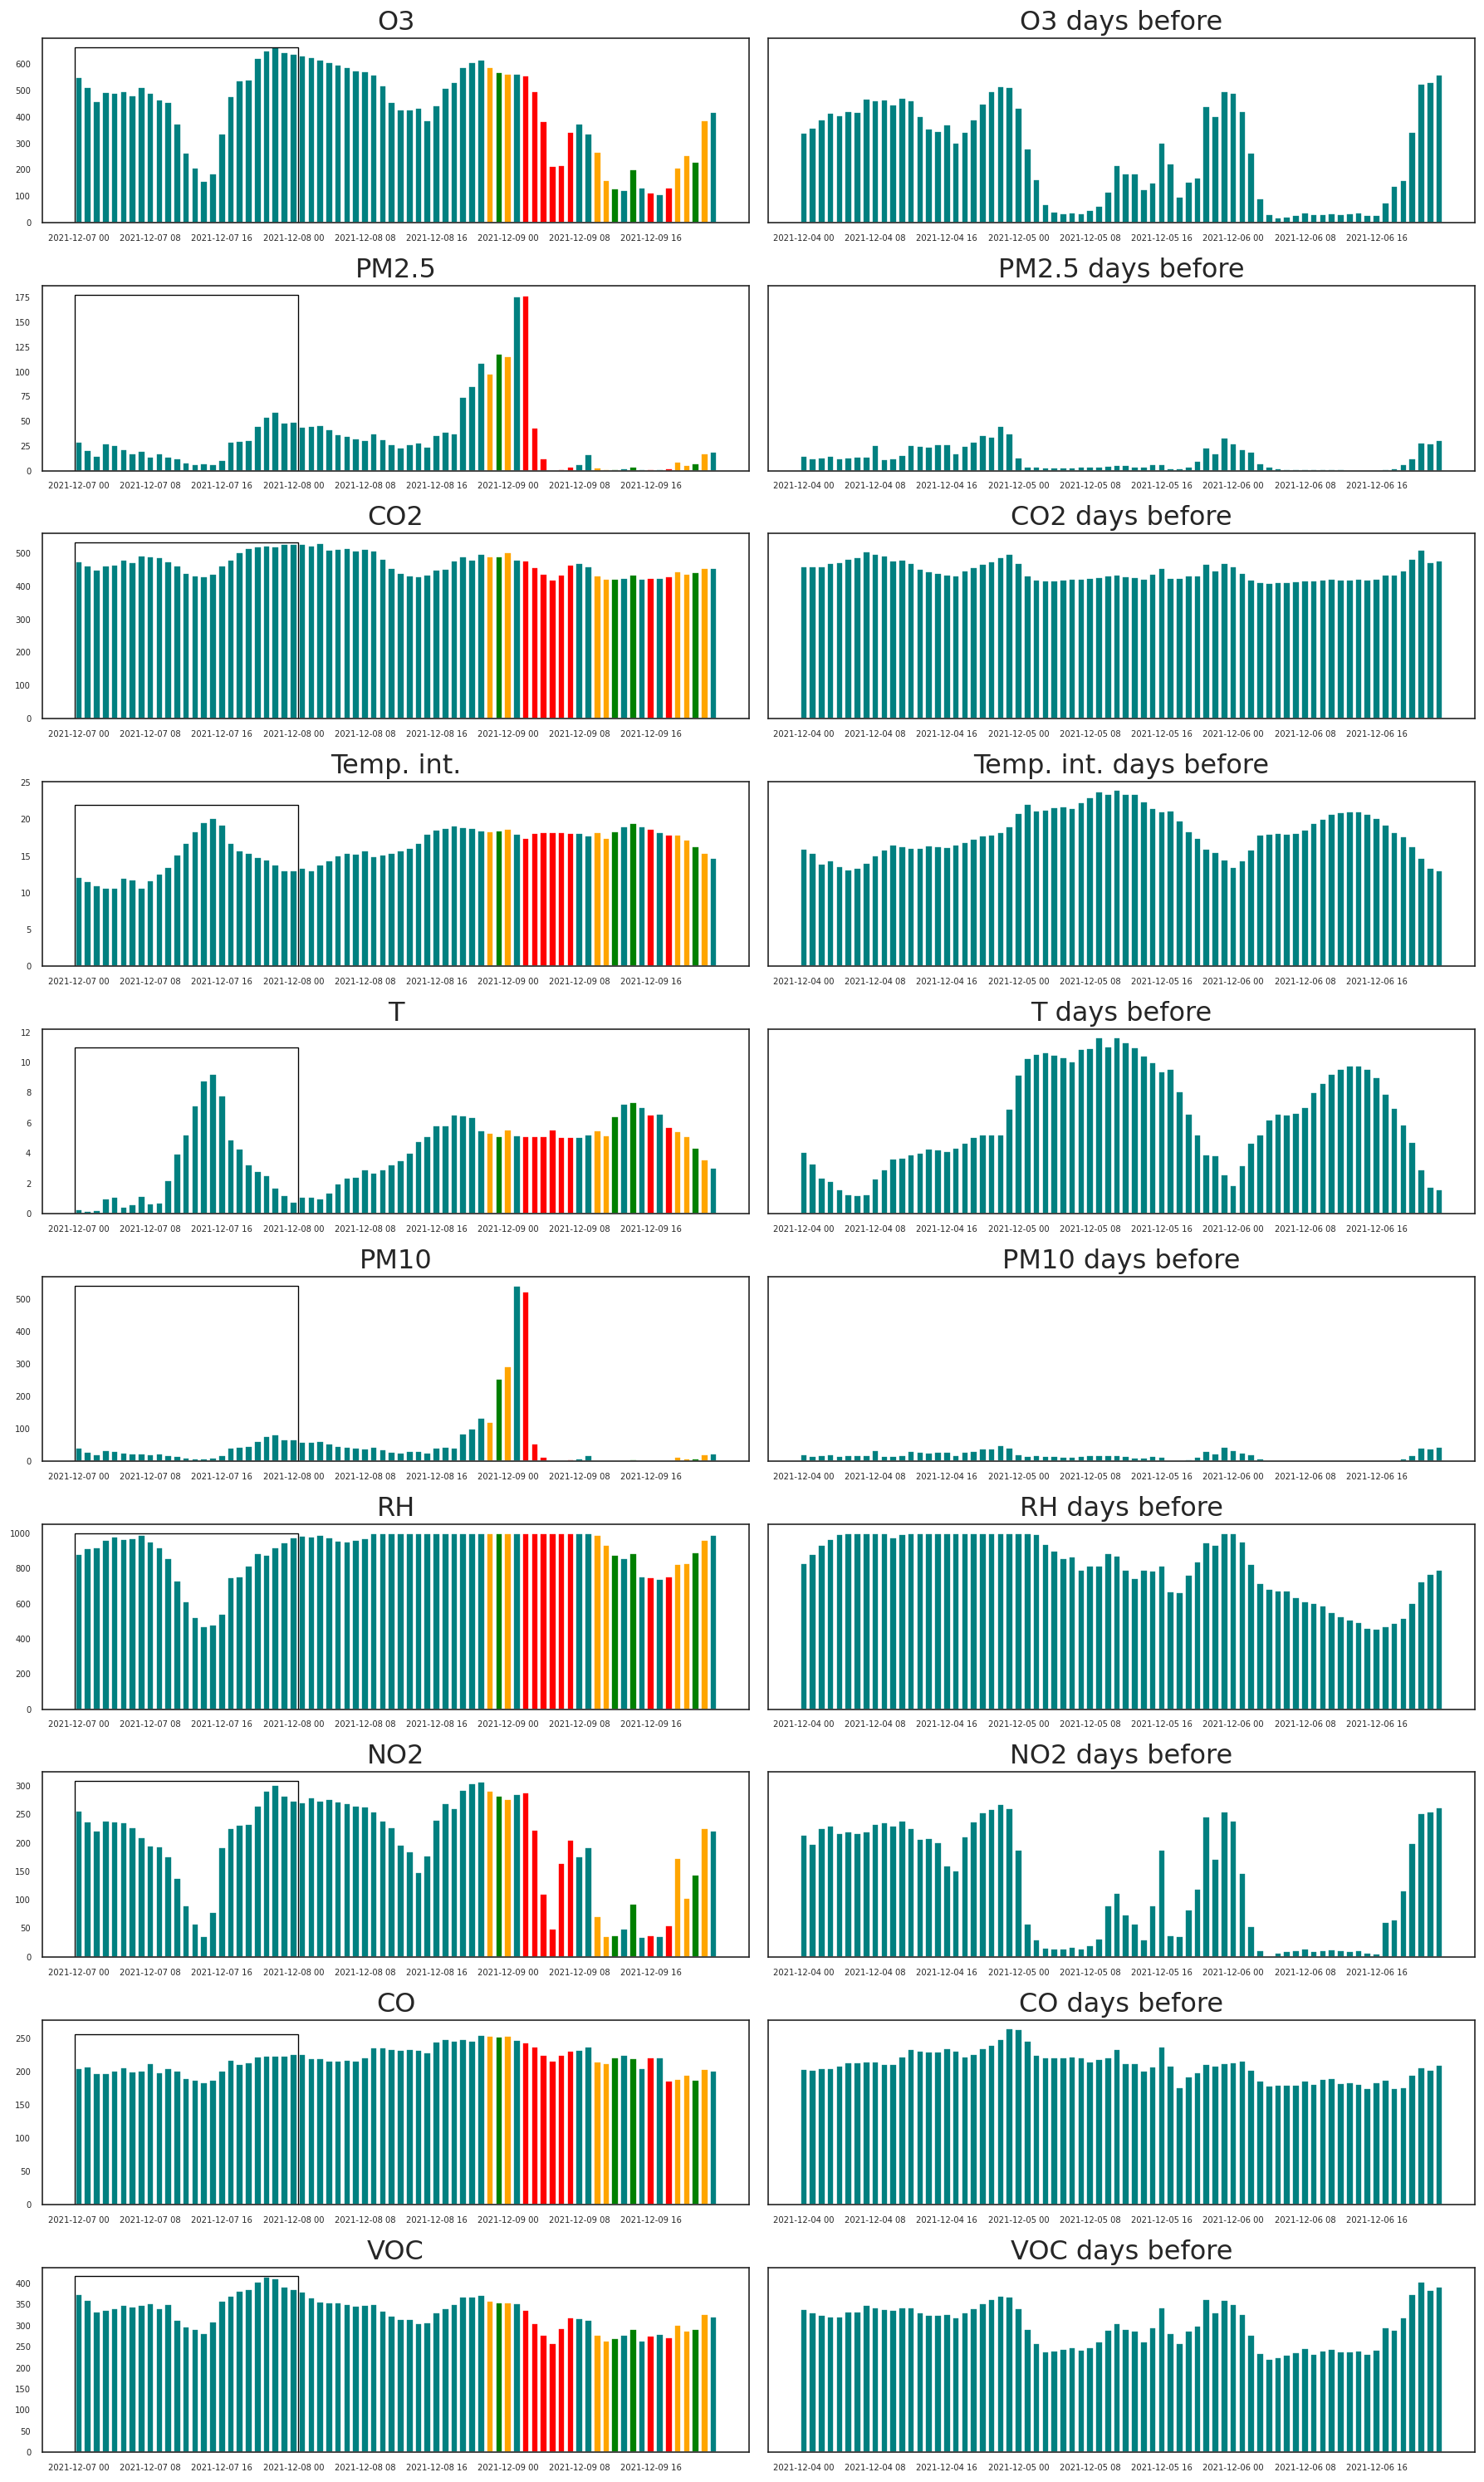

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib
%matplotlib inline

num_col=len(df_copy.columns)
# Plot
fig, axes = plt.subplots(nrows=num_col, ncols=2, sharey='row', dpi=120, figsize=(15,25))
x_ticks = np.arange(0, how_many, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_maha = data[df.columns[i/2]]
      ax.bar(data_maha.index, data_maha, color='teal', linewidth=1)
      ax.set_xticks(x_ticks)
      
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green',  linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange',  linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag, int(max(data[df.columns[i/2]])+2))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))

      # Decorations
      ax.set_title(df.columns[i/2])
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before[df.columns[(i-1)/2]]
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      # Decorations
      ax.set_title(df.columns[(i-1)/2]+' days before')
      ax.tick_params(labelsize=6)
      ax.set_xticks(x_ticks)

plt.tight_layout();


# Searching the anomalies using the euclidian distance for each variable

Testing stationarity

In [ ]:
df_e=df_copy.copy()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df_e, col)
    for col in df_e.columns
}
adf_test_results     

{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Converting to stationary with differencing.

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df_e.columns:
    df_e[col] = differencing(df_e, col, 1)

In [ ]:
from statsmodels.tsa.api import VAR
max_lag = 40
var_model = VAR(df_e)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag_eucl = lag_results.aic
print(selected_lag_eucl)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


25


In [ ]:
import numpy as np
import scipy as sp

#euclidian distance
def euclidian(x=None, data=None):
  distance = pd.DataFrame(index=df_copy.index[selected_lag_eucl:], columns=data.columns)
  for col in data.columns:
    distance[col]=abs((x[col]).values-(data[col]).values)
  return distance
var = VAR(df_e)
var_fitresults = var.fit(selected_lag_eucl)
var_summaryeucl=str(var_fitresults.summary())
print(var_summaryeucl[0:624])
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[selected_lag_eucl:], columns=df_e.columns)
distance = euclidian(x=var_fit_df, data= df_e.iloc[selected_lag_eucl:])
display(distance)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Feb, 2022
Time:                     18:19:24
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    37.4330
Nobs:                     3836.00    HQIC:                   34.7953
Log likelihood:          -115870.    FPE:                3.02739e+14
AIC:                      33.3420    Det(Omega_mle):     1.60623e+14
--------------------------------------------------------------------



,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-06-30 13,15.069985,1.042509,2.616161,1.298601,1.236425,2.789080,24.505699,1.764429,1.481614,10.167138
2021-06-30 14,23.528003,0.935588,3.650400,0.779873,0.707286,6.432237,8.780860,3.567335,1.213284,13.307873
2021-06-30 15,2.718145,0.481883,2.230947,0.061060,0.130328,5.258623,27.424941,15.588907,3.133933,3.732141
2021-06-30 16,28.278222,1.607216,0.542165,0.435782,0.219736,7.251504,31.360566,26.803394,9.245551,8.398536
2021-06-30 17,2.816566,0.458621,3.034176,0.070310,0.085542,2.904784,9.032611,20.128723,1.900323,4.004804
...,...,...,...,...,...,...,...,...,...,...
2021-12-09 19,16.601510,3.099147,2.301102,0.672835,0.741038,9.419053,5.541089,6.170554,0.222184,3.114421
2021-12-09 20,3.391880,3.631593,0.491435,0.790726,0.522401,4.037500,5.796532,12.971760,1.857986,6.285160
2021-12-09 21,4.515545,4.862659,0.276136,0.302807,0.111376,6.936762,26.516784,28.716412,6.930917,6.683561


# Distributions function code

In [ ]:
from scipy.stats import burr, beta, expon, norm, uniform, weibull_min, weibull_max, invgauss, gamma, lognorm, pearson3, triang
import matplotlib.pyplot as plt

Get how many variables the distribution needs to work correctly

In [ ]:
def get_num_var(distribution):
  if(distribution=='burr' or distribution=='beta'):
    num_var=2
  if(distribution=='invgauss' or distribution=='gamma' or distribution=='weibull_min' or distribution=='weibull_max' or distribution=='lognorm'
         or distribution=='pearson3' or distribution=='triang' ):
    num_var=1
  if(distribution=='expon' or distribution=='norm' or distribution=='uniform' ):
    num_var=0
  return num_var

In [ ]:
#distributions, convert from string to dis
distributions={"burr": burr, "beta": beta, "invgauss": invgauss, "gamma": gamma, "weibull_min": weibull_min, "weibull_max": weibull_max,
               "lognorm": lognorm, "pearson3": pearson3, "triang": triang, "expon": expon, "norm": norm, "uniform": uniform}

Function used to get the thresholds

In [ ]:
def get_thresholds(dis, param, min, max,num_var):
  low, med, high= 0.975,0.99,0.995
  find= np.linspace(min+((max-min)/1000),max*1.5, 2000)
  x = np.linspace(min+((max-min)/1000),max, 1000)
  fig, ax = plt.subplots(1, 1)
  #0 variables
  if(num_var==0):
    loc, scale = param[0], param[1]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i, loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
  #1 variables
  if(num_var==1):
    c= param[0]
    loc, scale = param[1], param[2]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x,c, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i, c,loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i,c, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i,c, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
  #3 variables
  if(num_var==2):
    c,d= param[0], param[1]
    loc, scale = param[2], param[3]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x,c,d, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i,c,d, loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i,c,d, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i,c,d, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
  return threshold_l, threshold_m, threshold_h

# Testing the distance's distributions and finding the thresholds

Make histograms

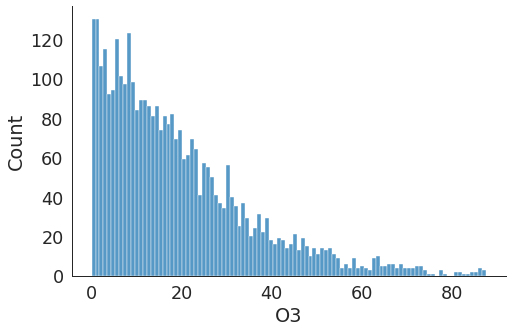

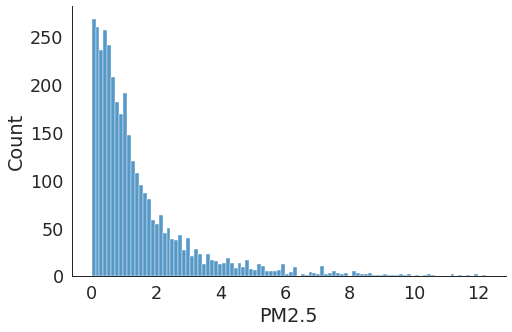

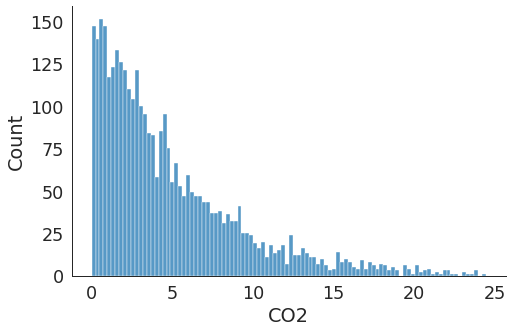

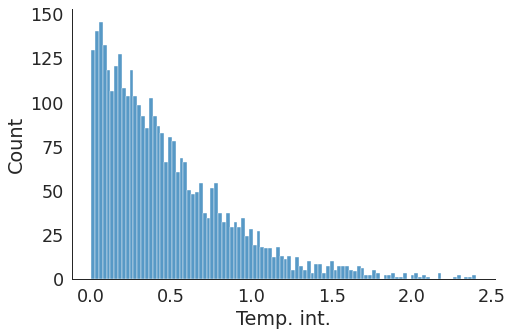

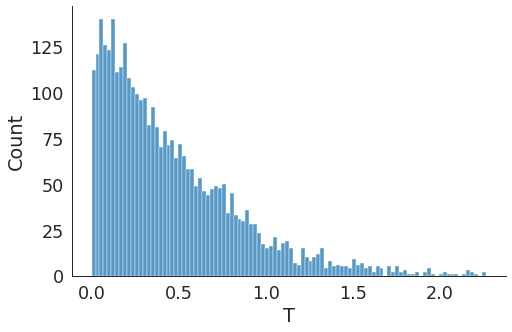

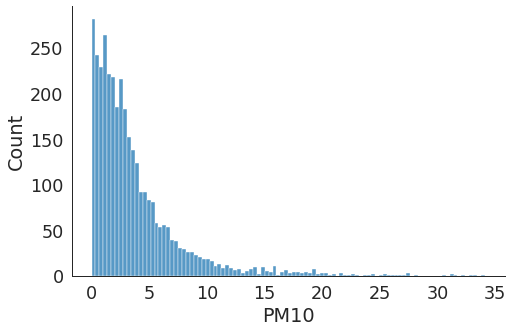

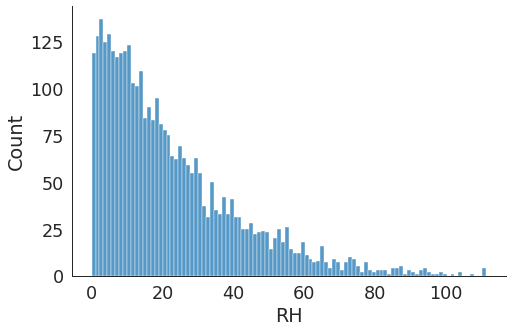

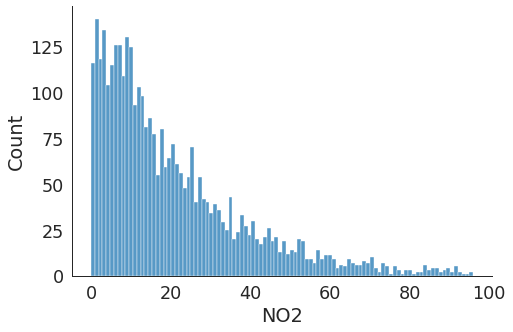

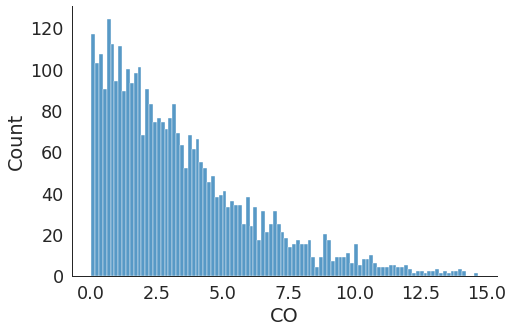

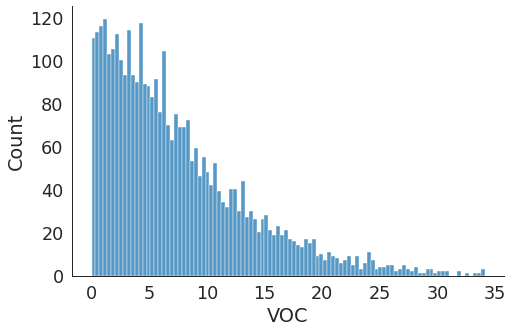

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

#remove outliers
z_scores = stats.zscore(distance)

abs_z_scores = np.abs(z_scores)
filtered_distance = (abs_z_scores < 3).all(axis=1)
new_distance = distance[filtered_distance]

for col in df.columns:
  sns.set_style('white')
  sns.set_context("paper", font_scale = 2)
  sns.displot(data=new_distance, x=col, kind="hist", bins = 100, aspect = 1.5)

Find the best distribution (the output ranks the best distributions in ascending order)

          sumsquare_error          aic           bic  kl_div
burr             0.000377  1090.846010 -56073.195028     inf
beta             0.000435  1071.376023 -55565.737797     inf
pearson3         0.000658  1061.569918 -54129.117545     inf
gamma            0.000658  1061.569735 -54129.116582     inf
expon            0.001001  1050.691193 -52672.513046     inf


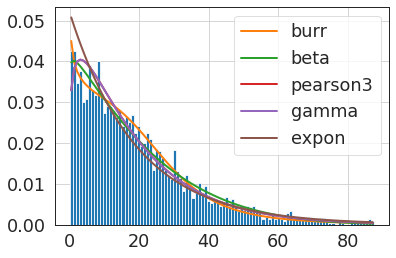

In [ ]:
dis = new_distance["O3"].values
O3_min=min(dis)
O3_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_O=f.fitted_param[distribution]

62.52464602161798 82.5686788566008 101.49550330406


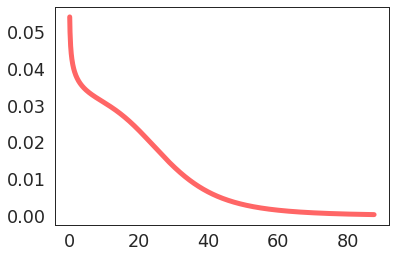

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_O3_l, threshold_O3_m, threshold_O3_h= get_thresholds(dis, param_O, O3_min, O3_max,num_var)
print(threshold_O3_l, threshold_O3_m, threshold_O3_h)


             sumsquare_error         aic           bic  kl_div
burr                0.019990  852.699551 -42183.710693     inf
expon               0.049551  925.479229 -39025.631455     inf
beta                0.052079  934.065448 -38835.304742     inf
pearson3            0.057010  921.585159 -38527.088998     inf
weibull_min         0.068441  895.005618 -37888.061801     inf


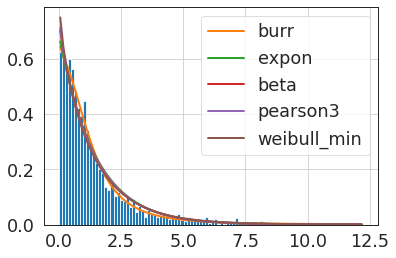

In [ ]:
dis = new_distance["PM2.5"].values
PM2_min=min(dis)
PM2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_P=f.fitted_param[distribution]

6.5601224479006754 10.218690304508435 14.234862538077856


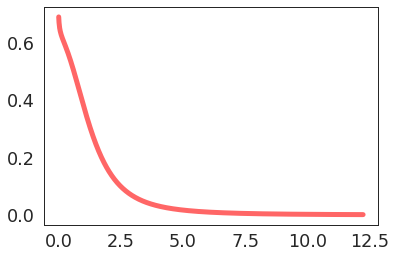

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_PM2_l, threshold_PM2_m, threshold_PM2_h= get_thresholds(dis, param_P, PM2_min, PM2_max,num_var)
print(threshold_PM2_l, threshold_PM2_m, threshold_PM2_h)


             sumsquare_error         aic           bic  kl_div
weibull_min         0.004475  837.687621 -47425.916051     inf
gamma               0.004577  835.181100 -47346.867252     inf
pearson3            0.004577  835.181136 -47346.863897     inf
beta                0.005906  845.607992 -46447.504851     inf
expon               0.006819  826.007518 -45961.342131     inf


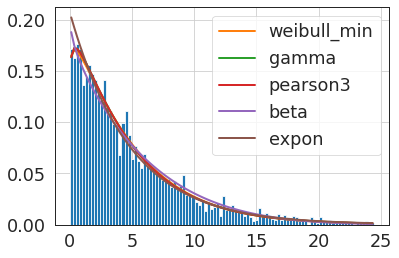

In [ ]:
dis = new_distance["CO2"].values
CO2_min=min(dis)
CO2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_CO2=f.fitted_param[distribution]

16.77772289186223 20.645133591316725 23.541109375742366


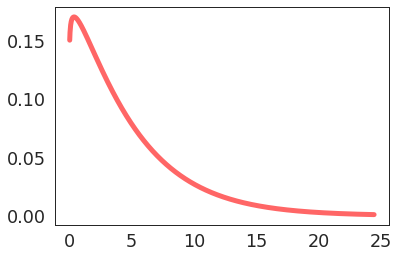

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_CO2_l, threshold_CO2_m, threshold_CO2_h= get_thresholds(dis, param_CO2, CO2_min, CO2_max,num_var)
print(threshold_CO2_l, threshold_CO2_m, threshold_CO2_h)


             sumsquare_error         aic           bic  kl_div
beta                0.404551  409.070027 -31666.399720     inf
weibull_min         0.493990  396.228791 -30976.076646     inf
burr                0.598765  414.137003 -30295.255913     inf
pearson3            0.612210  386.933253 -30225.761868     inf
gamma               0.612308  386.949088 -30225.202251     inf


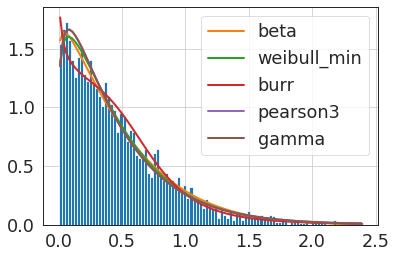

In [ ]:
dis = new_distance["Temp. int."].values
Temp_min=min(dis)
Temp_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_Temp= f.fitted_param[distribution]

1.4876093949662355 1.7521724396780671 1.932147300026252


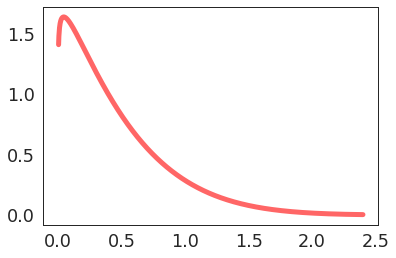

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_Temp_l, threshold_Temp_m, threshold_Temp_h= get_thresholds(dis, param_Temp, Temp_min, Temp_max,num_var)
print(threshold_Temp_l, threshold_Temp_m, threshold_Temp_h)

             sumsquare_error         aic           bic  kl_div
beta                0.326992  380.372693 -32410.705533     inf
weibull_min         0.356667  370.922628 -32115.094071     inf
pearson3            0.420397  363.424274 -31540.198525     inf
gamma               0.420471  363.438742 -31539.583110     inf
burr                0.855138  378.809260 -29048.950390     inf


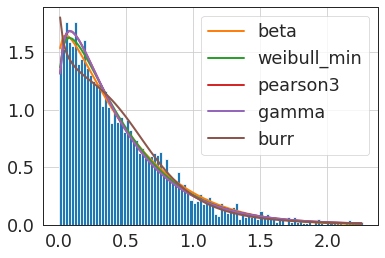

In [ ]:
dis = new_distance["T"].values
T_min=min(dis)
T_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_T=f.fitted_param[distribution]

1.4470344944318139 1.7050641128630968 1.8816106938950272


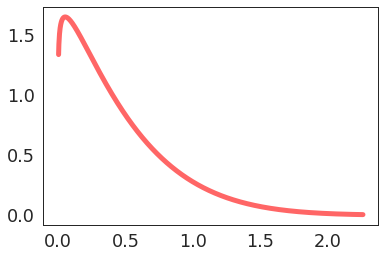

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_T_l, threshold_T_m, threshold_T_h= get_thresholds(dis, param_T, T_min, T_max,num_var)
print(threshold_T_l, threshold_T_m, threshold_T_h)

             sumsquare_error          aic           bic  kl_div
burr                0.002522  1106.845206 -49422.633408     inf
beta                0.006599  1195.750072 -46059.620203     inf
pearson3            0.006653  1192.488539 -46039.208092     inf
expon               0.007492  1182.709239 -45631.968142     inf
weibull_min         0.008122  1178.851685 -45341.681637     inf


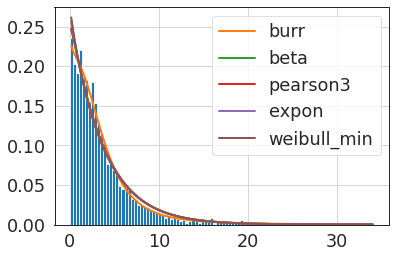

In [ ]:
dis = new_distance["PM10"].values
PM10_min=min(dis)
PM10_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_PM10=f.fitted_param[distribution]

15.112541478140063 22.408353436349945 30.062556157419255


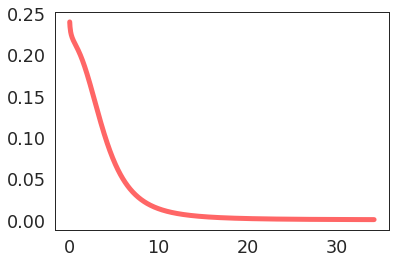

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_PM10_l, threshold_PM10_m, threshold_PM10_h= get_thresholds(dis, param_PM10, PM10_min, PM10_max,num_var)
print(threshold_PM10_l, threshold_PM10_m, threshold_PM10_h)


          sumsquare_error          aic           bic  kl_div
beta             0.000133  1157.636089 -59719.577599     inf
gamma            0.000156  1141.417849 -59174.051889     inf
pearson3         0.000156  1141.418488 -59174.019683     inf
burr             0.000285  1157.441326 -57053.314038     inf
expon            0.000518  1124.451855 -54977.094167     inf


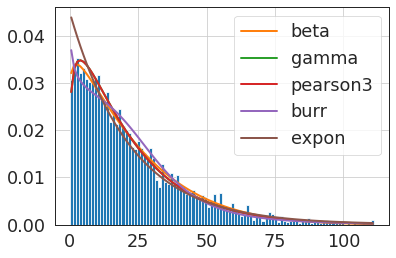

In [ ]:
dis = new_distance["RH"].values
RH_min=min(dis)
RH_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_RH=f.fitted_param[distribution]

71.43654309496449 84.19933612028638 93.04153259534597


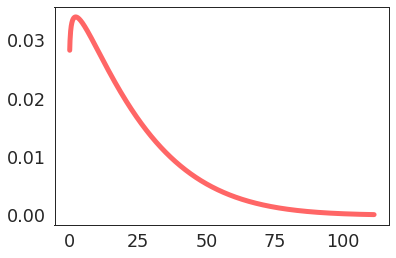

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_RH_l, threshold_RH_m, threshold_RH_h= get_thresholds(dis, param_RH, RH_min, RH_max,num_var)
print(threshold_RH_l, threshold_RH_m, threshold_RH_h)


          sumsquare_error          aic           bic    kl_div
pearson3         0.000390  1087.279494 -55962.824921  0.015740
gamma            0.000390  1087.279535 -55962.824761  0.015740
beta             0.000520  1091.413626 -54941.714574  0.019445
burr             0.000528  1089.017504 -54892.296031  0.018603
expon            0.000694  1077.284130 -53950.367015  0.019396


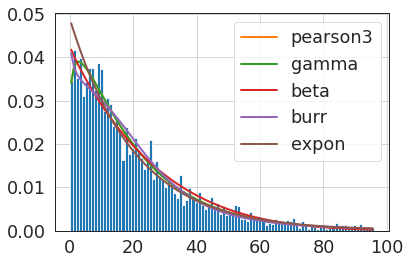

In [ ]:
dis = new_distance["NO2"].values
NO2_min=min(dis)
NO2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_NO2=f.fitted_param[distribution]

70.97467900577918 87.74088058975791 100.33352126442004


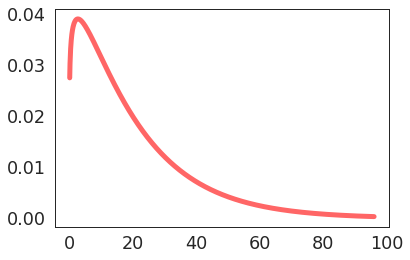

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_NO2_l, threshold_NO2_m, threshold_NO2_h= get_thresholds(dis, param_NO2, NO2_min, NO2_max,num_var)
print(threshold_NO2_l, threshold_NO2_m, threshold_NO2_h)

          sumsquare_error         aic           bic  kl_div
beta             0.013135  706.973757 -43652.435559     inf
burr             0.017340  720.443695 -42681.145628     inf
pearson3         0.019574  694.522621 -42265.505410     inf
gamma            0.019575  694.527172 -42265.282990     inf
expon            0.038235  683.289715 -39932.231673     inf


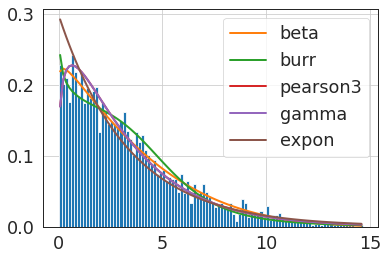

In [ ]:
dis = new_distance["CO"].values
CO_min=min(dis)
CO_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_CO=f.fitted_param[distribution]

10.244052439602518 11.760320091111232 12.72721540511679


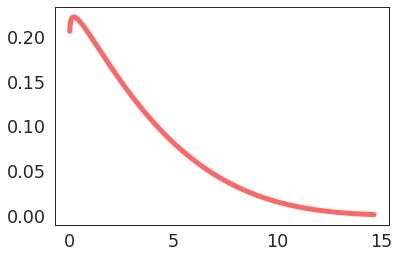

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_CO_l, threshold_CO_m, threshold_CO_h= get_thresholds(dis, param_CO, CO_min, CO_max,num_var)
print(threshold_CO_l, threshold_CO_m, threshold_CO_h)

          sumsquare_error         aic           bic  kl_div
beta             0.002259  896.827558 -49808.444932     inf
burr             0.003098  910.769568 -48704.185653     inf
gamma            0.003226  880.757465 -48570.284887     inf
pearson3         0.003226  880.759230 -48570.224489     inf
expon            0.007900  865.303063 -45446.427026     inf


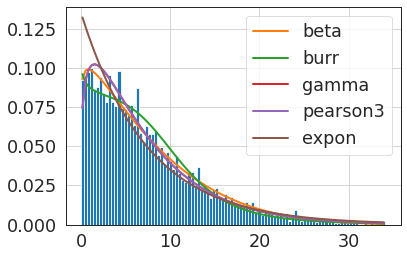

In [ ]:
dis = new_distance["VOC"].values
VOC_min=min(dis)
VOC_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_VOC=f.fitted_param[distribution]

22.89507583575782 26.551738469599876 28.98098986970474


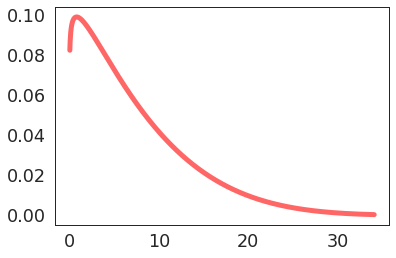

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_VOC_l, threshold_VOC_m, threshold_VOC_h= get_thresholds(dis, param_VOC, VOC_min, VOC_max,num_var)
print(threshold_VOC_l, threshold_VOC_m, threshold_VOC_h)


# Using the thresholds to search anomalies 

In [ ]:
to_show=72
def find_anomalies_thresholds(errors, threshold_low, threshold_med, threshold_high):
  predictions=pd.DataFrame(np.zeros((len(errors), 1)))
  for i in range(len(errors)):
    if((errors.iloc[i] >= threshold_low) &(errors.iloc[i] < threshold_med)):
      predictions.iloc[i]=1
    if((errors.iloc[i] >= threshold_med) &(errors.iloc[i]< threshold_high)):
      predictions.iloc[i]=2
    if(errors.iloc[i] >= threshold_high):
      predictions.iloc[i]=3
  return predictions

data_thresh=df_copy.iloc[-to_show:,:]

Finding anomalies with the burr distribution (O3)

In [ ]:
predictions_O3 = find_anomalies_thresholds(distance['O3'], threshold_O3_l, threshold_O3_m, threshold_O3_h)

data_thresh['Predictions_O3'] = predictions_O3.iloc[-to_show:,:].values
data_thresh['Predictions_O3'].value_counts()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    67
1.0     4
2.0     1
Name: Predictions_O3, dtype: int64

Finding anomalies with the burr distribution (PM2.5)

In [ ]:
predictions_PM2 = find_anomalies_thresholds(distance['PM2.5'], threshold_PM2_l, threshold_PM2_m, threshold_PM2_h)

data_thresh['Predictions_PM2.5'] = predictions_PM2.iloc[-to_show:,:].values
data_thresh['Predictions_PM2.5'].value_counts()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    51
1.0     8
3.0     7
2.0     6
Name: Predictions_PM2.5, dtype: int64

Finding anomalies with the burr distribution (CO2)

In [ ]:
predictions_CO2 = find_anomalies_thresholds(distance['CO2'], threshold_CO2_l, threshold_CO2_m, threshold_CO2_h)

data_thresh['Predictions_CO2'] = predictions_CO2.iloc[-to_show:,:].values
data_thresh['Predictions_CO2'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    65
1.0     7
Name: Predictions_CO2, dtype: int64

Finding anomalies with the beta distribution (Temp. int.)

In [ ]:
predictions_Temp = find_anomalies_thresholds(distance['Temp. int.'], threshold_Temp_l, threshold_Temp_m, threshold_Temp_h)

data_thresh['Predictions_Temp. int.'] = predictions_Temp.iloc[-to_show:,:].values
data_thresh['Predictions_Temp. int.'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    70
2.0     1
1.0     1
Name: Predictions_Temp. int., dtype: int64

Finding anomalies with the burr distribution (T)


In [ ]:
predictions_T = find_anomalies_thresholds(distance['T'], threshold_T_l, threshold_T_m, threshold_T_h)

data_thresh['Predictions_T'] = predictions_T.iloc[-to_show:,:].values
data_thresh['Predictions_T'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    70
3.0     2
Name: Predictions_T, dtype: int64

Finding anomalies with the burr distribution (PM10)

In [ ]:
predictions_PM10 = find_anomalies_thresholds(distance['PM10'], threshold_PM10_l, threshold_PM10_m, threshold_PM10_h)

data_thresh['Predictions_PM10'] = predictions_PM10.iloc[-to_show:,:].values
data_thresh['Predictions_PM10'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    56
1.0     7
3.0     7
2.0     2
Name: Predictions_PM10, dtype: int64

Finding anomalies with the burr distribution (RH)

In [ ]:
predictions_RH = find_anomalies_thresholds(distance['RH'], threshold_RH_l, threshold_RH_m, threshold_RH_h)

data_thresh['Predictions_RH'] = predictions_RH.iloc[-to_show:,:].values
data_thresh['Predictions_RH'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    70
3.0     1
2.0     1
Name: Predictions_RH, dtype: int64

Finding anomalies with the burr distribution (NO2)

In [ ]:
predictions_NO2 = find_anomalies_thresholds(distance['NO2'], threshold_NO2_l, threshold_NO2_m, threshold_NO2_h)

data_thresh['Predictions_NO2'] = predictions_NO2.iloc[-to_show:,:].values
data_thresh['Predictions_NO2'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    71
1.0     1
Name: Predictions_NO2, dtype: int64

Finding anomalies with the burr distribution (CO)

In [ ]:
predictions_CO = find_anomalies_thresholds(distance['CO'], threshold_CO_l, threshold_CO_m, threshold_CO_h)

data_thresh['Predictions_CO'] = predictions_CO.iloc[-to_show:,:].values
data_thresh['Predictions_CO'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    69
1.0     2
3.0     1
Name: Predictions_CO, dtype: int64

Finding anomalies with the beta distribution (VOC)

In [ ]:
predictions_VOC = find_anomalies_thresholds(distance['VOC'], threshold_VOC_l, threshold_VOC_m, threshold_VOC_h)

data_thresh['Predictions_VOC'] = predictions_VOC.iloc[-to_show:,:].values
data_thresh['Predictions_VOC'].value_counts()
display(data_thresh[-50:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions_O3,Predictions_PM2.5,Predictions_CO2,Predictions_Temp. int.,Predictions_T,Predictions_PM10,Predictions_RH,Predictions_NO2,Predictions_CO,Predictions_VOC
Dates,,,,,,,,,,,,,,,,,,,,
2021-12-07 22,661.750000,59.625000,521.250000,13.821750,1.715000,83.425000,917.450000,301.425000,222.975000,410.975000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-07 23,641.923077,48.102564,526.820513,13.050256,1.225641,66.153846,948.666667,282.487179,223.282051,393.128205,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-12-08 00,635.125000,49.200000,529.025000,12.965500,0.800000,67.175000,978.200000,273.475000,225.800000,386.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-08 01,629.435897,44.256410,527.358974,13.414359,1.084615,58.794872,988.025641,271.743590,225.512821,380.358974,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-12-08 02,622.666667,45.194444,523.611111,13.063056,1.094444,60.583333,982.555556,279.388889,219.833333,366.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-08 03,614.461538,45.923077,531.076923,13.817692,1.010256,61.051282,992.871795,274.692308,220.128205,355.769231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-08 04,605.675000,41.550000,510.800000,14.397500,1.387500,54.575000,976.625000,277.125000,216.175000,355.350000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-08 05,596.025641,36.717949,511.666667,15.006410,1.994872,46.897436,955.846154,272.461538,216.461538,353.871795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-08 06,586.350000,34.700000,514.300000,15.451750,2.345000,44.325000,955.025000,269.600000,217.575000,350.775000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create a table with results and differenced data

In [ ]:
data_diff=data_thresh.copy()
for col in df_copy.columns:
  data_diff[col]=df_e[col].iloc[-to_show:]

# Showing the anomalies (differenced values) found with the euclidian distance with graphs

In [ ]:
show_data_diff=data_diff.iloc[-to_show:,:]
day_before= df_e.iloc[-(to_show*3):-to_show,:]
x_ticks = np.arange(0, to_show, 8)
x_ticks_before= np.arange(0, to_show*2, 16)

Using this differencing out[i] = arr[i+1] – arr[i]

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

def show_anomalies_euclidian(anomalies_l, anomalies_m, anomalies_h, col):
  # Plot
  fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
  plt.setp(axes, xticks=x_ticks)
  for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      ax.bar(show_data_diff.index, 0)
      data_temp = show_data_diff[(data_diff['Predictions_'+col] == 0)][col]
      ax.bar(data_temp.index, data_temp ,color='teal',alpha=0.7, linewidth=1)
      data_expeted= var_fit_df[col].iloc[-to_show:]
      ax.set_xticks(x_ticks)    
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green',alpha=0.7,  linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange',alpha=0.7, linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red',alpha=0.7, linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_diff[col]+2)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))
      ax.bar(data_expeted.index, data_expeted ,fill = False, edgecolor = 'black', linewidth=0.5)


      # Decorations
      ax.set_title(col)
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before[col]
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks_before)
      # Decorations
      ax.set_title(col+' days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

  plt.tight_layout();


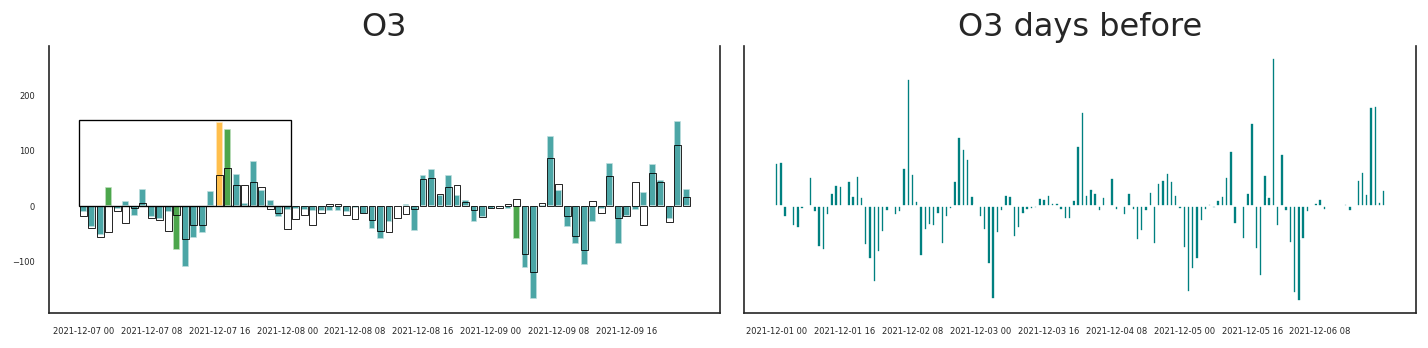

In [ ]:
anomalies_O3_l= show_data_diff[(data_diff['Predictions_O3'] == 1)]
anomalies_O3_m= show_data_diff[(data_diff['Predictions_O3'] == 2)]
anomalies_O3_h= show_data_diff[(data_diff['Predictions_O3'] == 3)]

show_anomalies_euclidian(anomalies_O3_l, anomalies_O3_m, anomalies_O3_h, 'O3')

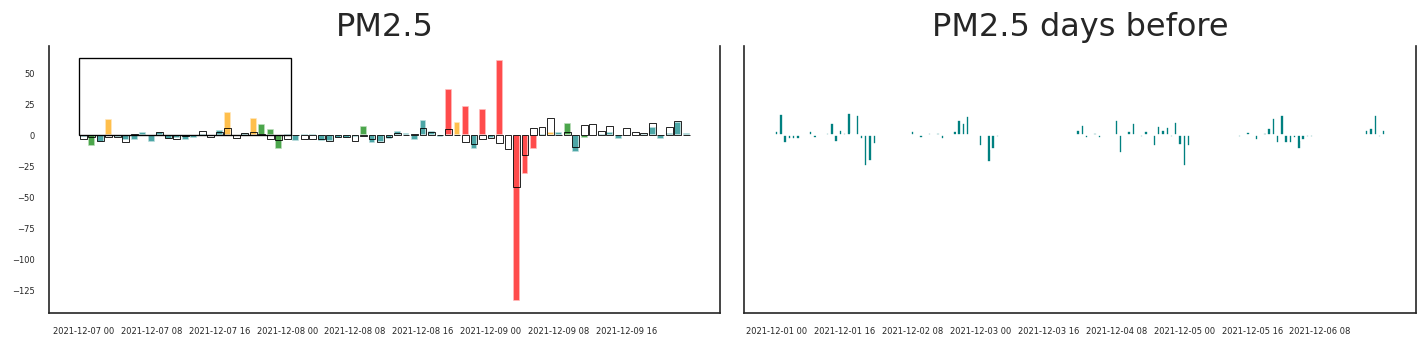

In [ ]:
anomalies_PM2_l= show_data_diff[(data_diff['Predictions_PM2.5'] == 1)]
anomalies_PM2_m= show_data_diff[(data_diff['Predictions_PM2.5'] == 2)]
anomalies_PM2_h= show_data_diff[(data_diff['Predictions_PM2.5'] == 3)]

show_anomalies_euclidian(anomalies_PM2_l, anomalies_PM2_m, anomalies_PM2_h, 'PM2.5')

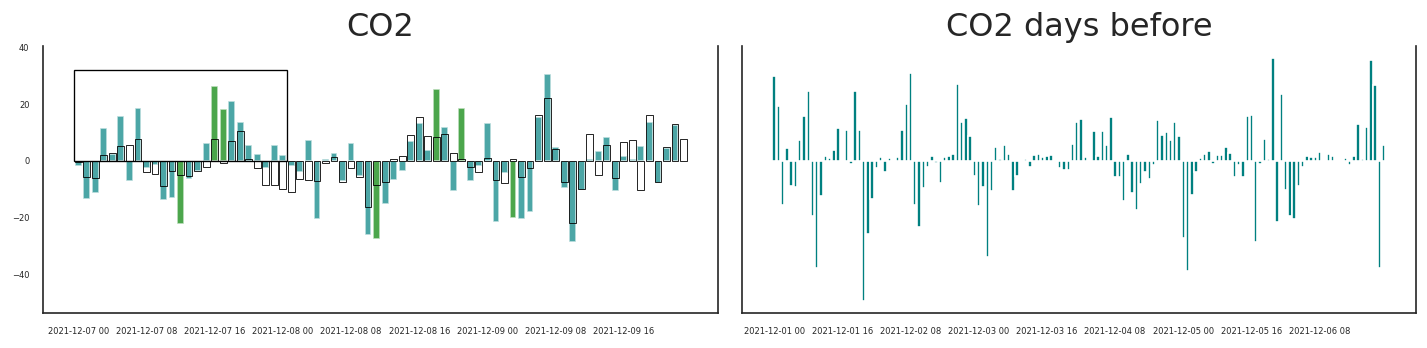

In [ ]:
anomalies_CO2_l= show_data_diff[(data_diff['Predictions_CO2'] == 1)]
anomalies_CO2_m= show_data_diff[(data_diff['Predictions_CO2'] == 2)]
anomalies_CO2_h= show_data_diff[(data_diff['Predictions_CO2'] == 3)]

show_anomalies_euclidian(anomalies_CO2_l, anomalies_CO2_m, anomalies_CO2_h, 'CO2')

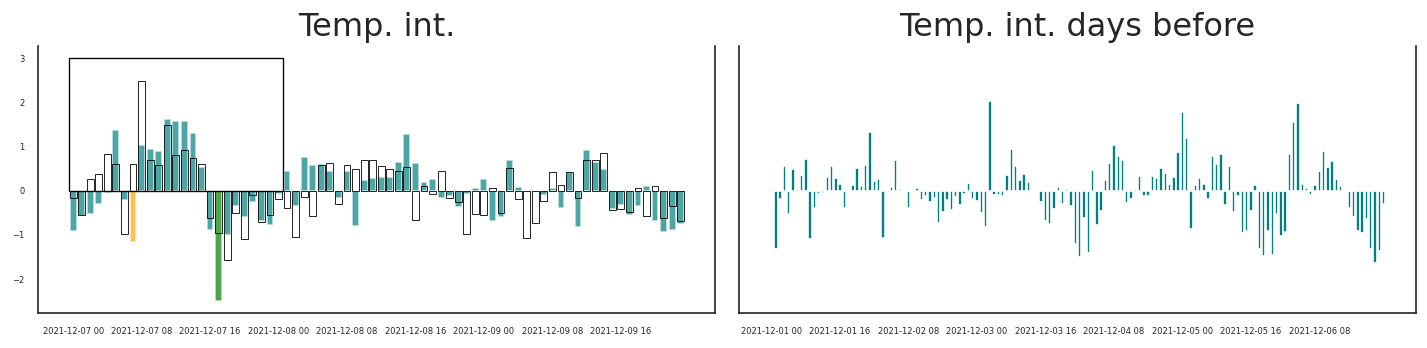

In [ ]:
anomalies_Temp_l= show_data_diff[(data_diff['Predictions_Temp. int.'] == 1)]
anomalies_Temp_m= show_data_diff[(data_diff['Predictions_Temp. int.'] == 2)]
anomalies_Temp_h= show_data_diff[(data_diff['Predictions_Temp. int.'] == 3)]


show_anomalies_euclidian(anomalies_Temp_l, anomalies_Temp_m, anomalies_Temp_h, 'Temp. int.')

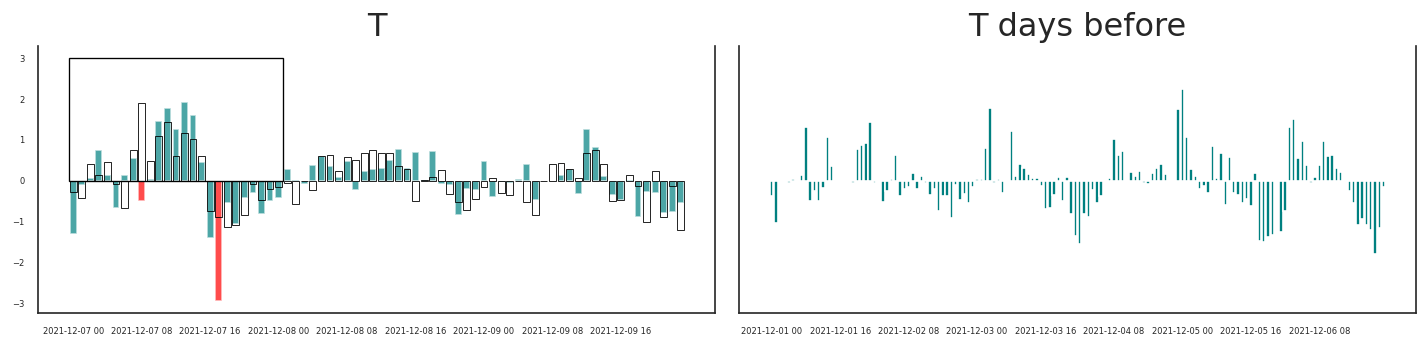

In [ ]:
anomalies_T_l= show_data_diff[(data_diff['Predictions_T'] == 1)]
anomalies_T_m= show_data_diff[(data_diff['Predictions_T'] == 2)]
anomalies_T_h= show_data_diff[(data_diff['Predictions_T'] == 3)]

show_anomalies_euclidian(anomalies_T_l, anomalies_T_m, anomalies_T_h, 'T')

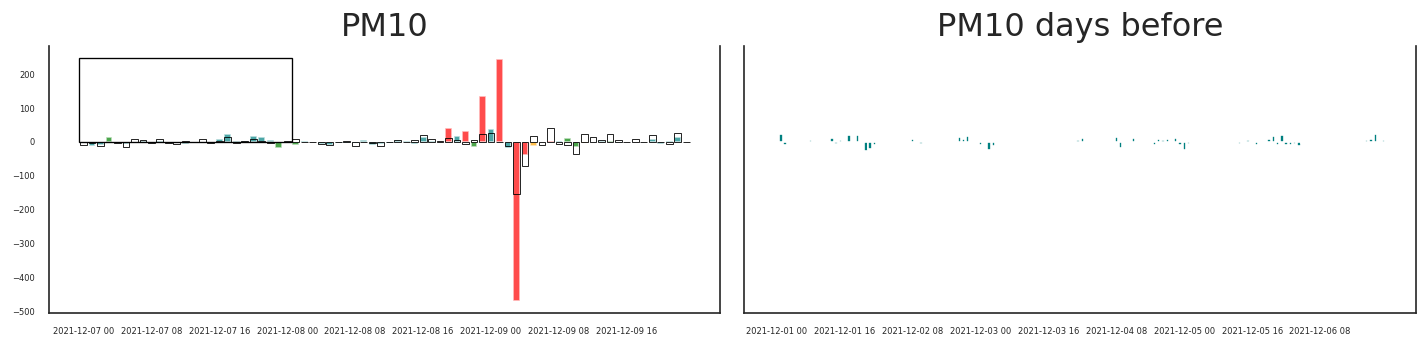

In [ ]:
anomalies_PM10_l= show_data_diff[(data_diff['Predictions_PM10'] == 1)]
anomalies_PM10_m= show_data_diff[(data_diff['Predictions_PM10'] == 2)]
anomalies_PM10_h= show_data_diff[(data_diff['Predictions_PM10'] == 3)]

show_anomalies_euclidian(anomalies_PM10_l, anomalies_PM10_m, anomalies_PM10_h, 'PM10')

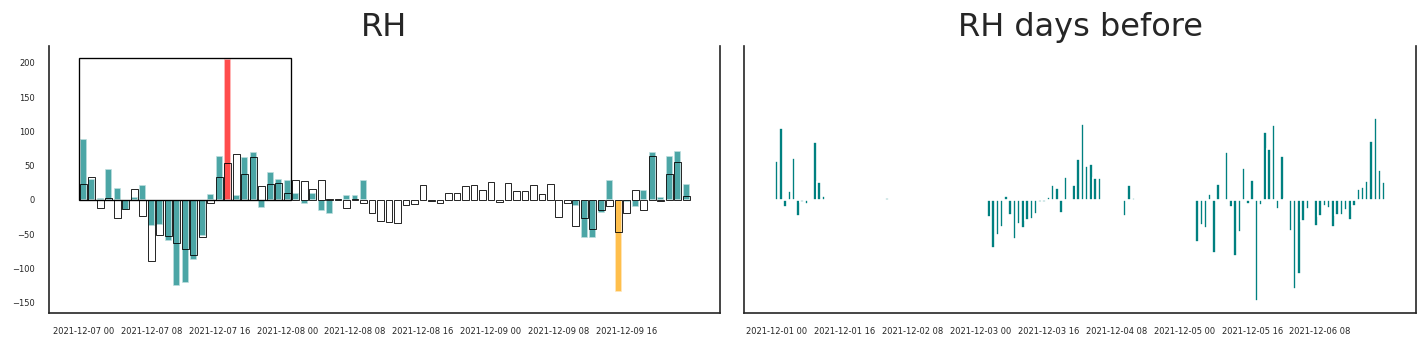

In [ ]:
anomalies_RH_l= show_data_diff[(data_diff['Predictions_RH'] == 1)]
anomalies_RH_m= show_data_diff[(data_diff['Predictions_RH'] == 2)]
anomalies_RH_h= show_data_diff[(data_diff['Predictions_RH'] == 3)]

show_anomalies_euclidian(anomalies_RH_l, anomalies_RH_m, anomalies_RH_h, 'RH')

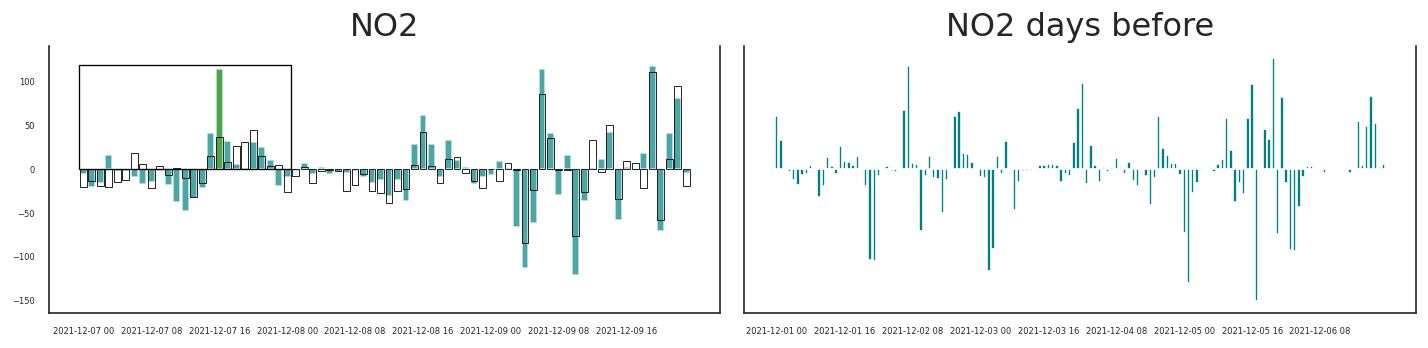

In [ ]:
anomalies_NO2_l= show_data_diff[(data_diff['Predictions_NO2'] == 1)]
anomalies_NO2_m= show_data_diff[(data_diff['Predictions_NO2'] == 2)]
anomalies_NO2_h= show_data_diff[(data_diff['Predictions_NO2'] == 3)]

show_anomalies_euclidian(anomalies_NO2_l, anomalies_NO2_m, anomalies_NO2_h, 'NO2')

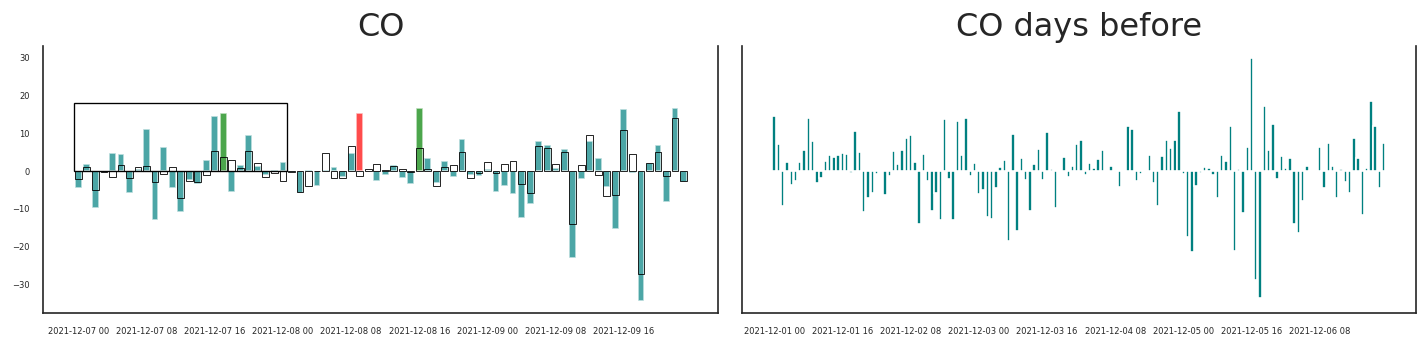

In [ ]:
anomalies_CO_l= show_data_diff[(data_diff['Predictions_CO'] == 1)]
anomalies_CO_m= show_data_diff[(data_diff['Predictions_CO'] == 2)]
anomalies_CO_h= show_data_diff[(data_diff['Predictions_CO'] == 3)]

show_anomalies_euclidian(anomalies_CO_l, anomalies_CO_m, anomalies_CO_h, 'CO')

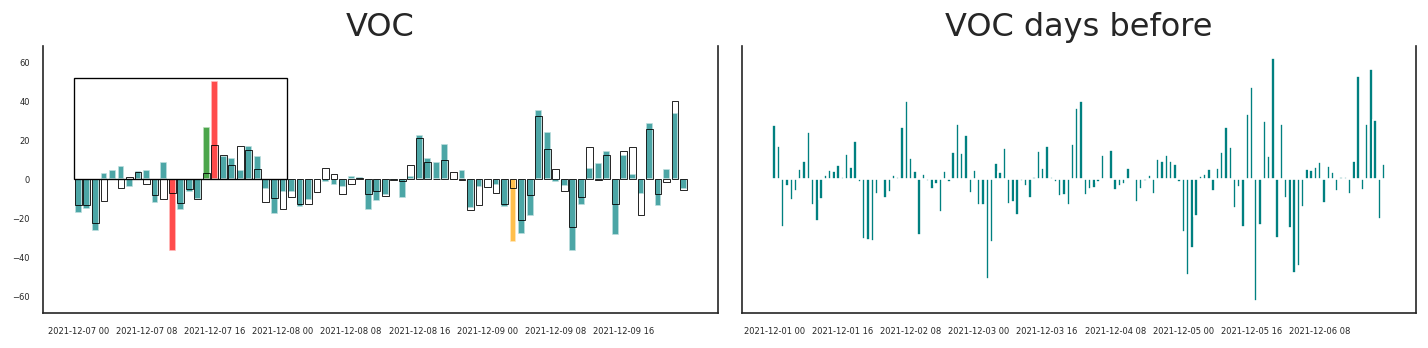

In [ ]:
anomalies_VOC_l= show_data_diff[(data_diff['Predictions_VOC'] == 1)]
anomalies_VOC_m= show_data_diff[(data_diff['Predictions_VOC'] == 2)]
anomalies_VOC_h= show_data_diff[(data_diff['Predictions_VOC'] == 3)]

show_anomalies_euclidian(anomalies_VOC_l, anomalies_VOC_m, anomalies_VOC_h, 'VOC')

# Showing the anomalies found with the euclidian distance with graphs

Reverse differencing the predicted values

In [ ]:
diff_range=6
many_times=to_show/diff_range
difference = pd.DataFrame(index=df_copy.index[-to_show:], columns=df_copy.columns)
for i in range(int(many_times)):
  if(i==many_times-1):
    temp = pd.DataFrame(index=df_copy.index[-diff_range-1:], columns=df_copy.columns)
  else:
    temp = pd.DataFrame(index=df_copy.index[-to_show-1+diff_range*i:-to_show+diff_range*(i+1)], columns=df_copy.columns)
  for col in df_copy.columns:
    if(i==many_times-1):
      x, x_diff = df_copy[col].iloc[-to_show-1+diff_range*i:-to_show+diff_range*i], var_fit_df[-diff_range:][col]
    else:
      x, x_diff = df_copy[col].iloc[-to_show-1+diff_range*i:-to_show+diff_range*i], var_fit_df[-to_show+diff_range*i:-to_show+diff_range*(i+1)][col]
    temp[col] = np.r_[x, x_diff].cumsum()
  #dopo il revert differencing i valori sono 7, non 6
  temp=temp.iloc[-diff_range:]
  if(i==many_times-1):
    difference.iloc[-diff_range:]=temp
  else:
    difference.iloc[-to_show+diff_range*i:-to_show+diff_range*(i+1)]=temp

In [ ]:
show_data_thresh=data_thresh.iloc[-to_show:,:]
day_before= df_copy.iloc[-(to_show*3):-to_show,:]
#lines= np.arange(0, to_show, diff_range)
x_ticks = np.arange(0, to_show, 8)
x_ticks_before= np.arange(0, to_show*2, 16)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

def show_anomalies_euclidian(anomalies_l, anomalies_m, anomalies_h, col):
  # Plot
  fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
  plt.setp(axes, xticks=x_ticks)
  for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      ax.bar(show_data_thresh.index, 0)
      data_temp = show_data_thresh[(data_thresh['Predictions_'+col] == 0)][col]
      ax.bar(data_temp.index, data_temp ,color='teal', alpha=1, linewidth=1)
      #ax.bar(difference[col].index, difference[col] ,color='black', alpha=0.5, linewidth=1)
      ax.set_xticks(x_ticks)    
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', alpha=1, linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', alpha=1, linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', alpha=1, linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_thresh[col]+2)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))
      #lines
      #for j in range(len(lines)):
       # ax.axvline(lines[j]	, color='black', alpha=0.3)

      # Decorations
      ax.set_title(col)
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before[col]
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks_before)
      # Decorations
      ax.set_title(col+' days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

  plt.tight_layout();


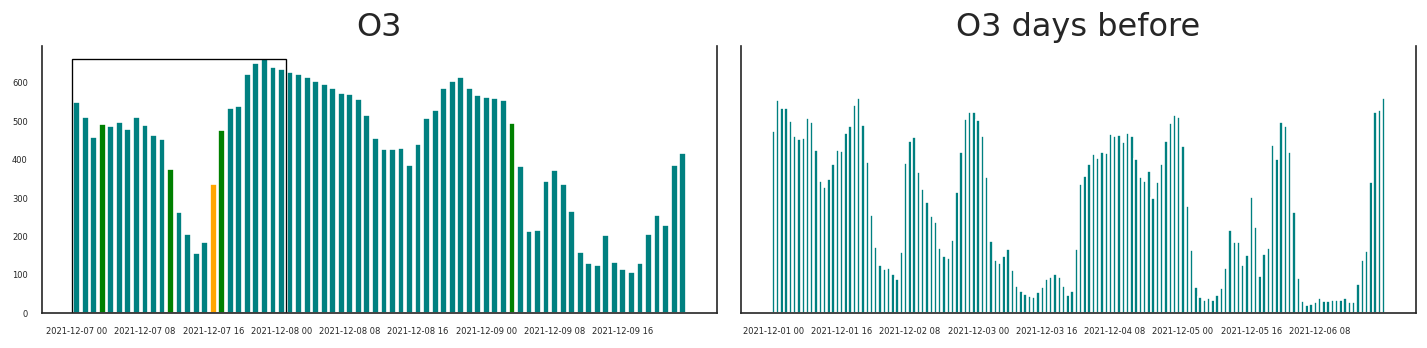

In [ ]:
anomalies_O3_l= show_data_thresh[(data_thresh['Predictions_O3'] == 1)]
anomalies_O3_m= show_data_thresh[(data_thresh['Predictions_O3'] == 2)]
anomalies_O3_h= show_data_thresh[(data_thresh['Predictions_O3'] == 3)]

show_anomalies_euclidian(anomalies_O3_l, anomalies_O3_m, anomalies_O3_h, 'O3')

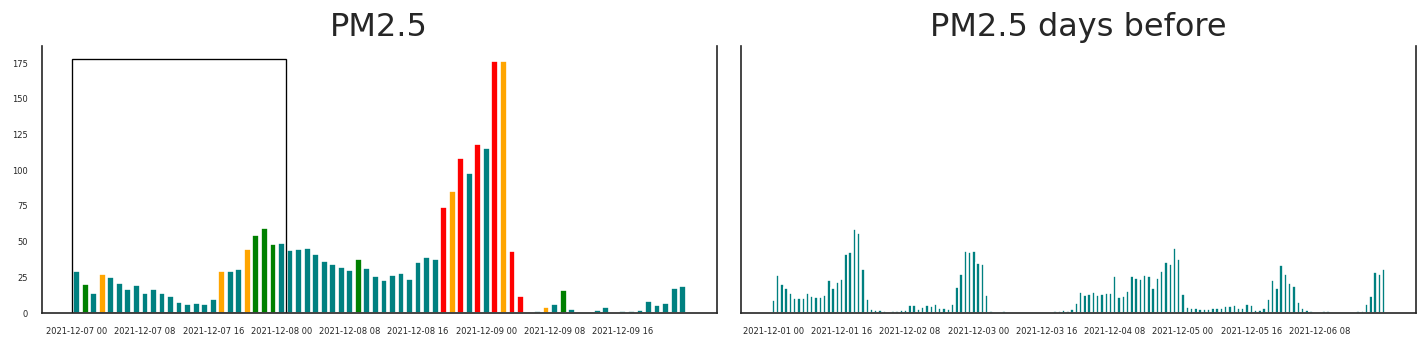

In [ ]:
anomalies_PM2_l= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 1)]
anomalies_PM2_m= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 2)]
anomalies_PM2_h= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 3)]

show_anomalies_euclidian(anomalies_PM2_l, anomalies_PM2_m, anomalies_PM2_h, 'PM2.5')

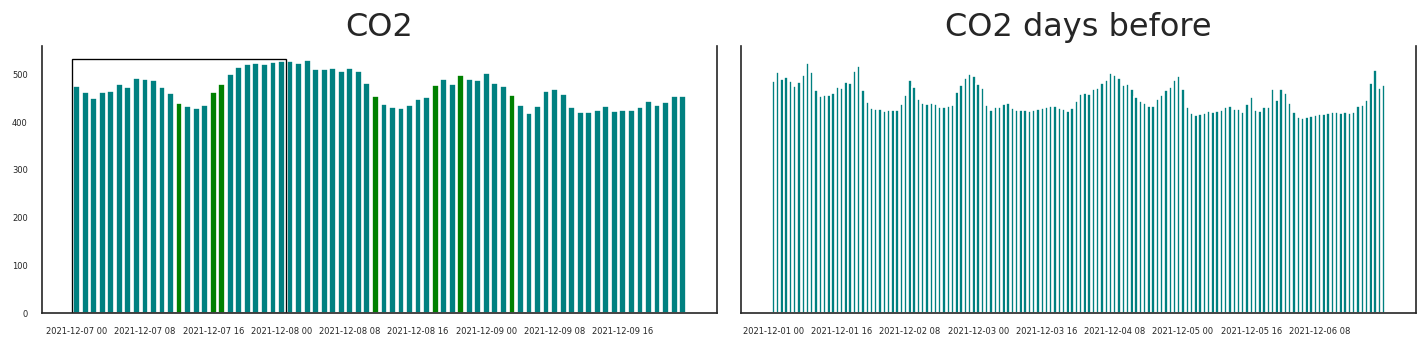

In [ ]:
anomalies_CO2_l= show_data_thresh[(data_thresh['Predictions_CO2'] == 1)]
anomalies_CO2_m= show_data_thresh[(data_thresh['Predictions_CO2'] == 2)]
anomalies_CO2_h= show_data_thresh[(data_thresh['Predictions_CO2'] == 3)]

show_anomalies_euclidian(anomalies_CO2_l, anomalies_CO2_m, anomalies_CO2_h, 'CO2')

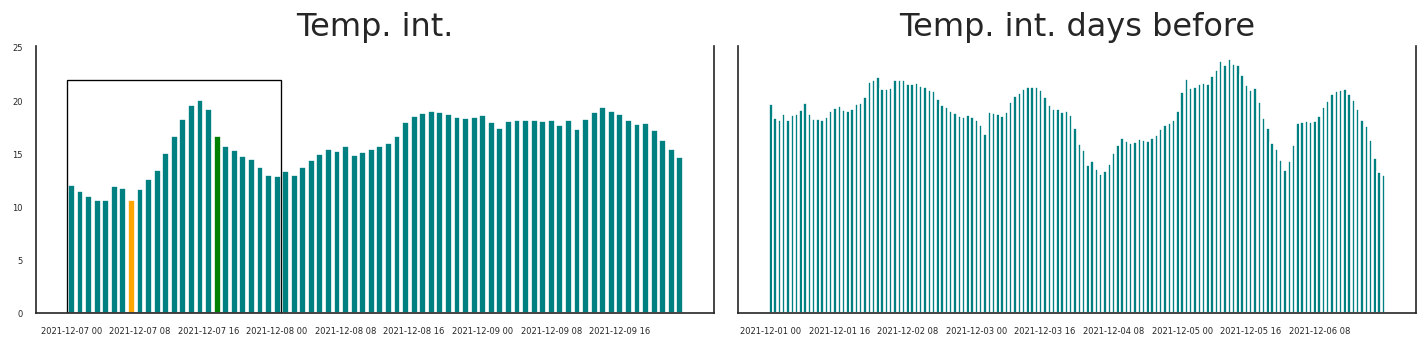

In [ ]:
anomalies_Temp_l= show_data_thresh[(data_thresh['Predictions_Temp. int.'] == 1)]
anomalies_Temp_m= show_data_thresh[(data_thresh['Predictions_Temp. int.'] == 2)]
anomalies_Temp_h= show_data_thresh[(data_thresh['Predictions_Temp. int.'] == 3)]


show_anomalies_euclidian(anomalies_Temp_l, anomalies_Temp_m, anomalies_Temp_h, 'Temp. int.')

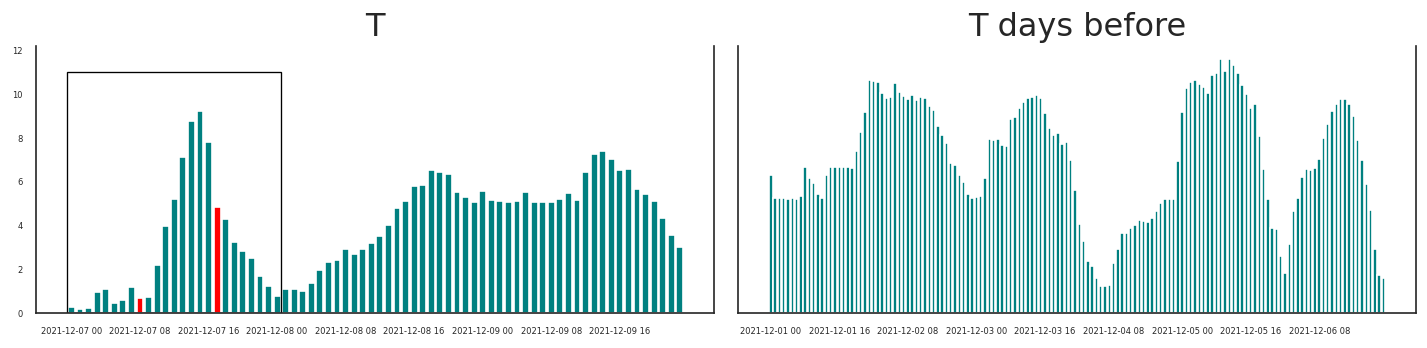

In [ ]:
anomalies_T_l= show_data_thresh[(data_thresh['Predictions_T'] == 1)]
anomalies_T_m= show_data_thresh[(data_thresh['Predictions_T'] == 2)]
anomalies_T_h= show_data_thresh[(data_thresh['Predictions_T'] == 3)]

show_anomalies_euclidian(anomalies_T_l, anomalies_T_m, anomalies_T_h, 'T')

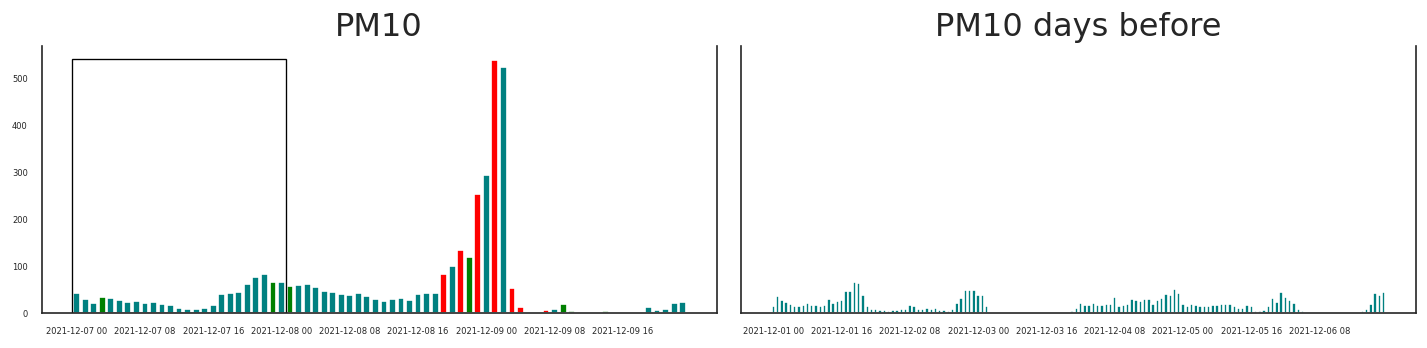

In [ ]:
anomalies_PM10_l= show_data_thresh[(data_thresh['Predictions_PM10'] == 1)]
anomalies_PM10_m= show_data_thresh[(data_thresh['Predictions_PM10'] == 2)]
anomalies_PM10_h= show_data_thresh[(data_thresh['Predictions_PM10'] == 3)]

show_anomalies_euclidian(anomalies_PM10_l, anomalies_PM10_m, anomalies_PM10_h, 'PM10')

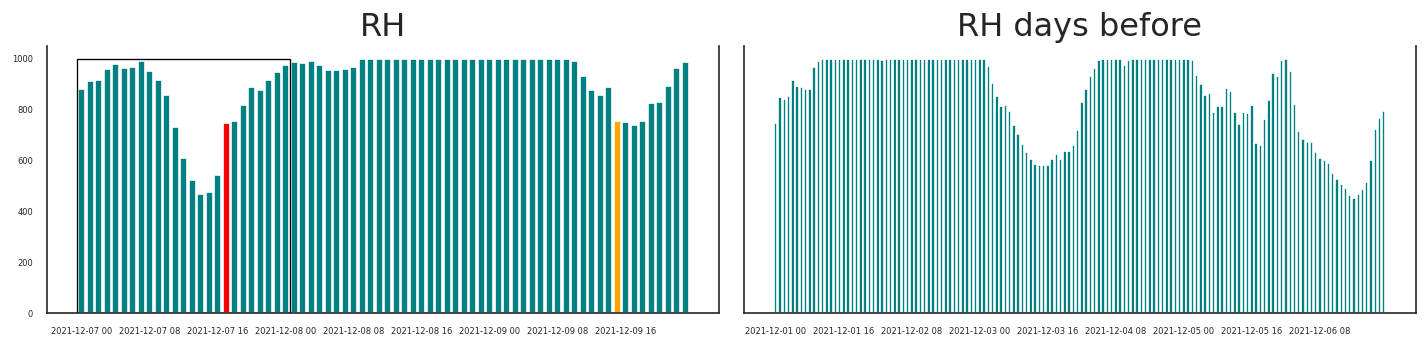

In [ ]:
anomalies_RH_l= show_data_thresh[(data_thresh['Predictions_RH'] == 1)]
anomalies_RH_m= show_data_thresh[(data_thresh['Predictions_RH'] == 2)]
anomalies_RH_h= show_data_thresh[(data_thresh['Predictions_RH'] == 3)]

show_anomalies_euclidian(anomalies_RH_l, anomalies_RH_m, anomalies_RH_h, 'RH')

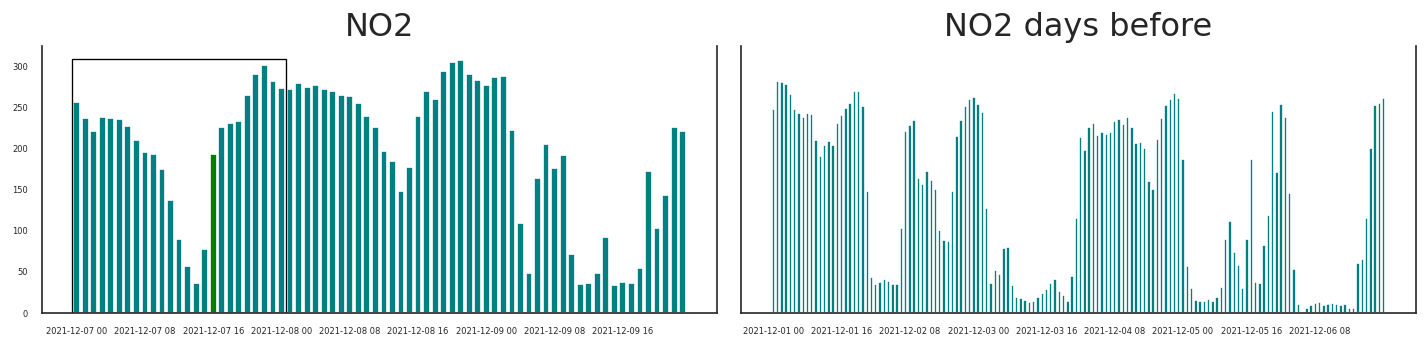

In [ ]:
anomalies_NO2_l= show_data_thresh[(data_thresh['Predictions_NO2'] == 1)]
anomalies_NO2_m= show_data_thresh[(data_thresh['Predictions_NO2'] == 2)]
anomalies_NO2_h= show_data_thresh[(data_thresh['Predictions_NO2'] == 3)]

show_anomalies_euclidian(anomalies_NO2_l, anomalies_NO2_m, anomalies_NO2_h, 'NO2')

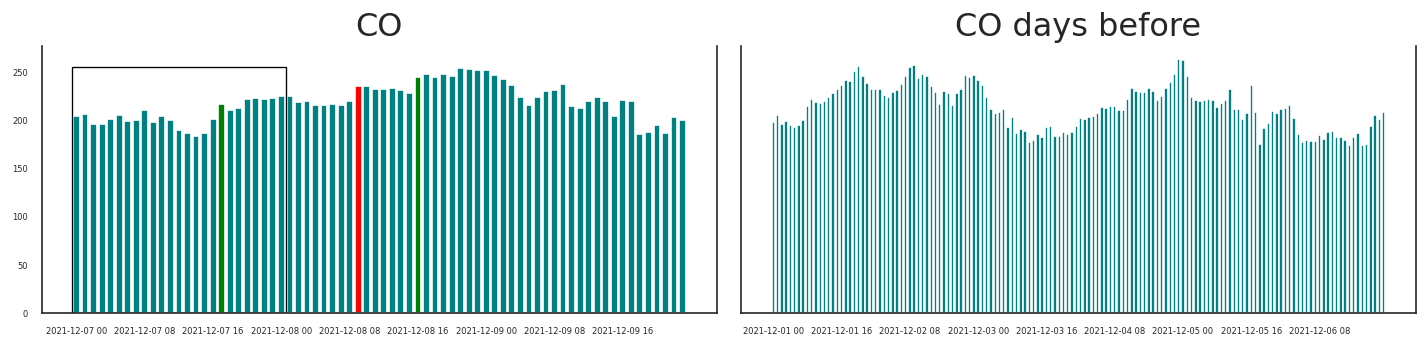

In [ ]:
anomalies_CO_l= show_data_thresh[(data_thresh['Predictions_CO'] == 1)]
anomalies_CO_m= show_data_thresh[(data_thresh['Predictions_CO'] == 2)]
anomalies_CO_h= show_data_thresh[(data_thresh['Predictions_CO'] == 3)]

show_anomalies_euclidian(anomalies_CO_l, anomalies_CO_m, anomalies_CO_h, 'CO')

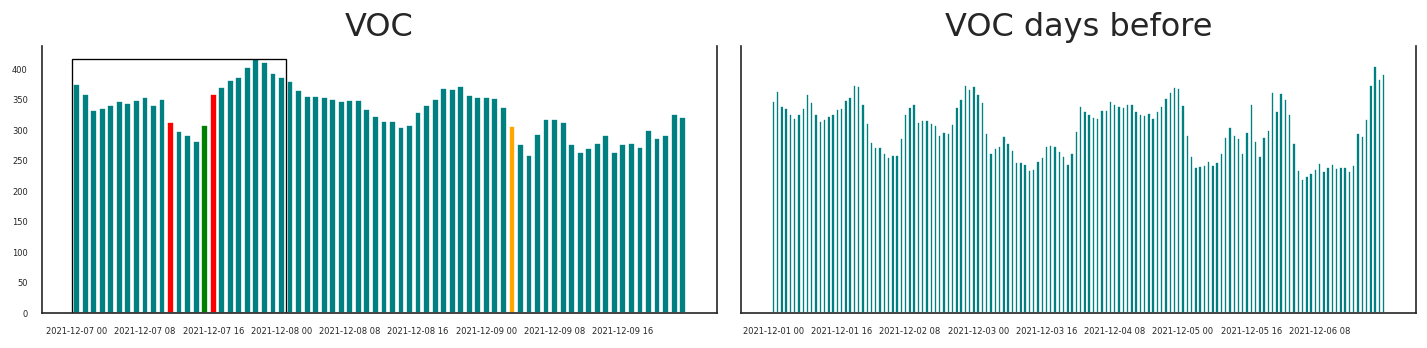

In [ ]:
anomalies_VOC_l= show_data_thresh[(data_thresh['Predictions_VOC'] == 1)]
anomalies_VOC_m= show_data_thresh[(data_thresh['Predictions_VOC'] == 2)]
anomalies_VOC_h= show_data_thresh[(data_thresh['Predictions_VOC'] == 3)]

show_anomalies_euclidian(anomalies_VOC_l, anomalies_VOC_m, anomalies_VOC_h, 'VOC')

# Forecast all

Splitting the series into train and testing data (to_predict= how many values are going to be predicted, forecast_interval= how often the forecast will happen)

to_predict must be a multiple of forecast_interval

In [ ]:
to_predict=48
forecast_interval = 6
df_train, df_test = df_copy[0:-to_predict].copy(), df_copy[-to_predict:].copy()
df_train_inputs=df_copy.copy()

# Check size
print(df_train.shape)  
print(df_test.shape)  

(3405, 10)
(48, 10)


Check stationarity with all values and only with the starting values

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results_end = {
    col: test_stationarity(df_train, col)
    for col in df_train.columns
}
display(adf_test_results_end)
  

{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Non-Stationary',
 'PM2.5': 'Non-Stationary',
 'RH': 'Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Use the differencing only on the variables that need it 

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df.columns:
    df_train[col] = differencing(df_train, col, 1)
#anche gli input devono essere post differencing se train viene differenziato e usato nel modello
for col in df.columns:
    df_train_inputs[col] = differencing(df_train_inputs, col, 1)

In [ ]:
from statsmodels.tsa.api import VAR

max_lag=40
model_lag = VAR(df_train.astype(float))
lag_results_for = model_lag.select_order(max_lag)
selected_lag_for = lag_results_for.aic
print(selected_lag_for)
df_inputs=df_train_inputs[-to_predict-selected_lag_for:-forecast_interval].copy()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


25


In [ ]:
res_fc=pd.DataFrame(index=df_copy.index[-to_predict:], columns=df_copy.columns)
how_many_times=to_predict/forecast_interval
allvalues=[]
model=VAR(df_train.astype(float))
model_fitted = model.fit(selected_lag_for)
var_summaryfor=str(model_fitted.summary())
print(var_summaryfor[0:624])
for i in range(int(how_many_times)):
  if(i==how_many_times-1):
    forecast_input = df_inputs.iloc[-selected_lag_for:].values
  else:
    forecast_input = df_inputs.iloc[(i)*forecast_interval:(i)*forecast_interval+selected_lag_for].values
  fc = model_fitted.forecast(y=forecast_input, steps=forecast_interval)
  if(i==how_many_times-1):
    temp = pd.DataFrame(fc, index=df_copy.index[-forecast_interval:], columns=df_copy.columns)
    diff= pd.DataFrame( index=df_copy.index[-forecast_interval-1:], columns=df.columns)
  else:
    temp = pd.DataFrame(fc, index=df_copy.index[-to_predict+i*forecast_interval:-to_predict+(i+1)*forecast_interval], columns=df_copy.columns)
    diff = pd.DataFrame(index=df_copy.index[-to_predict+i*forecast_interval-1:-to_predict+(i+1)*forecast_interval], columns=df.columns)
  for col in df.columns:
    x, x_diff = df_copy[col].iloc[-to_predict+i*forecast_interval-1:-to_predict+i*forecast_interval], temp[col]
    diff[col] = np.r_[x, x_diff].cumsum()
  #dopo il revert differencing i valori sono 7, non 6
  diff=diff.iloc[-forecast_interval:]
  for col in df.columns:
    temp[col]=diff[col]
  res_fc.iloc[i*forecast_interval:(i+1)*forecast_interval]=temp
display(res_fc)
  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Feb, 2022
Time:                     18:11:39
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    36.3145
Nobs:                     3380.00    HQIC:                   33.3919
Log likelihood:          -99133.9    FPE:                6.26323e+13
AIC:                      31.7656    Det(Omega_mle):     3.05987e+13
--------------------------------------------------------------------



,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-11-21 00,545.752736,53.618531,500.055485,20.388578,6.66573,81.875677,1066.726772,319.741368,221.80064,386.099104
2021-11-21 01,482.049815,61.286405,495.848736,18.045061,4.502955,134.741722,1163.865304,201.511683,215.077256,351.906547
2021-11-21 02,403.967034,79.687332,497.14952,14.009607,0.745613,236.055526,1293.530409,186.412138,216.050203,334.621448
2021-11-21 03,431.392838,92.089996,505.505603,12.738284,-0.783153,321.527963,1344.476727,271.684839,217.99101,355.468467
2021-11-21 04,458.524953,95.43815,495.847143,12.571832,-1.411429,349.897206,1371.38541,282.904201,216.78931,351.64859
2021-11-21 05,526.183998,95.602182,494.949596,13.910855,0.188418,362.886057,1365.925512,348.836181,233.675467,370.413985
2021-11-21 06,607.230365,55.106445,507.536012,24.01904,10.83371,121.163441,954.35289,377.117244,233.841238,380.681355
2021-11-21 07,665.563043,54.394376,499.560701,24.585463,11.21073,146.105103,980.640245,378.991746,241.819628,398.974669
2021-11-21 08,708.061399,52.841589,493.219069,24.540096,11.62065,149.52687,1003.728197,385.884779,249.802845,416.294285


In [ ]:
fc_index=res_fc.index
for_index=[]
for i in range(len(fc_index)):
  if(i%forecast_interval==0):
    for_index.append(fc_index[i])

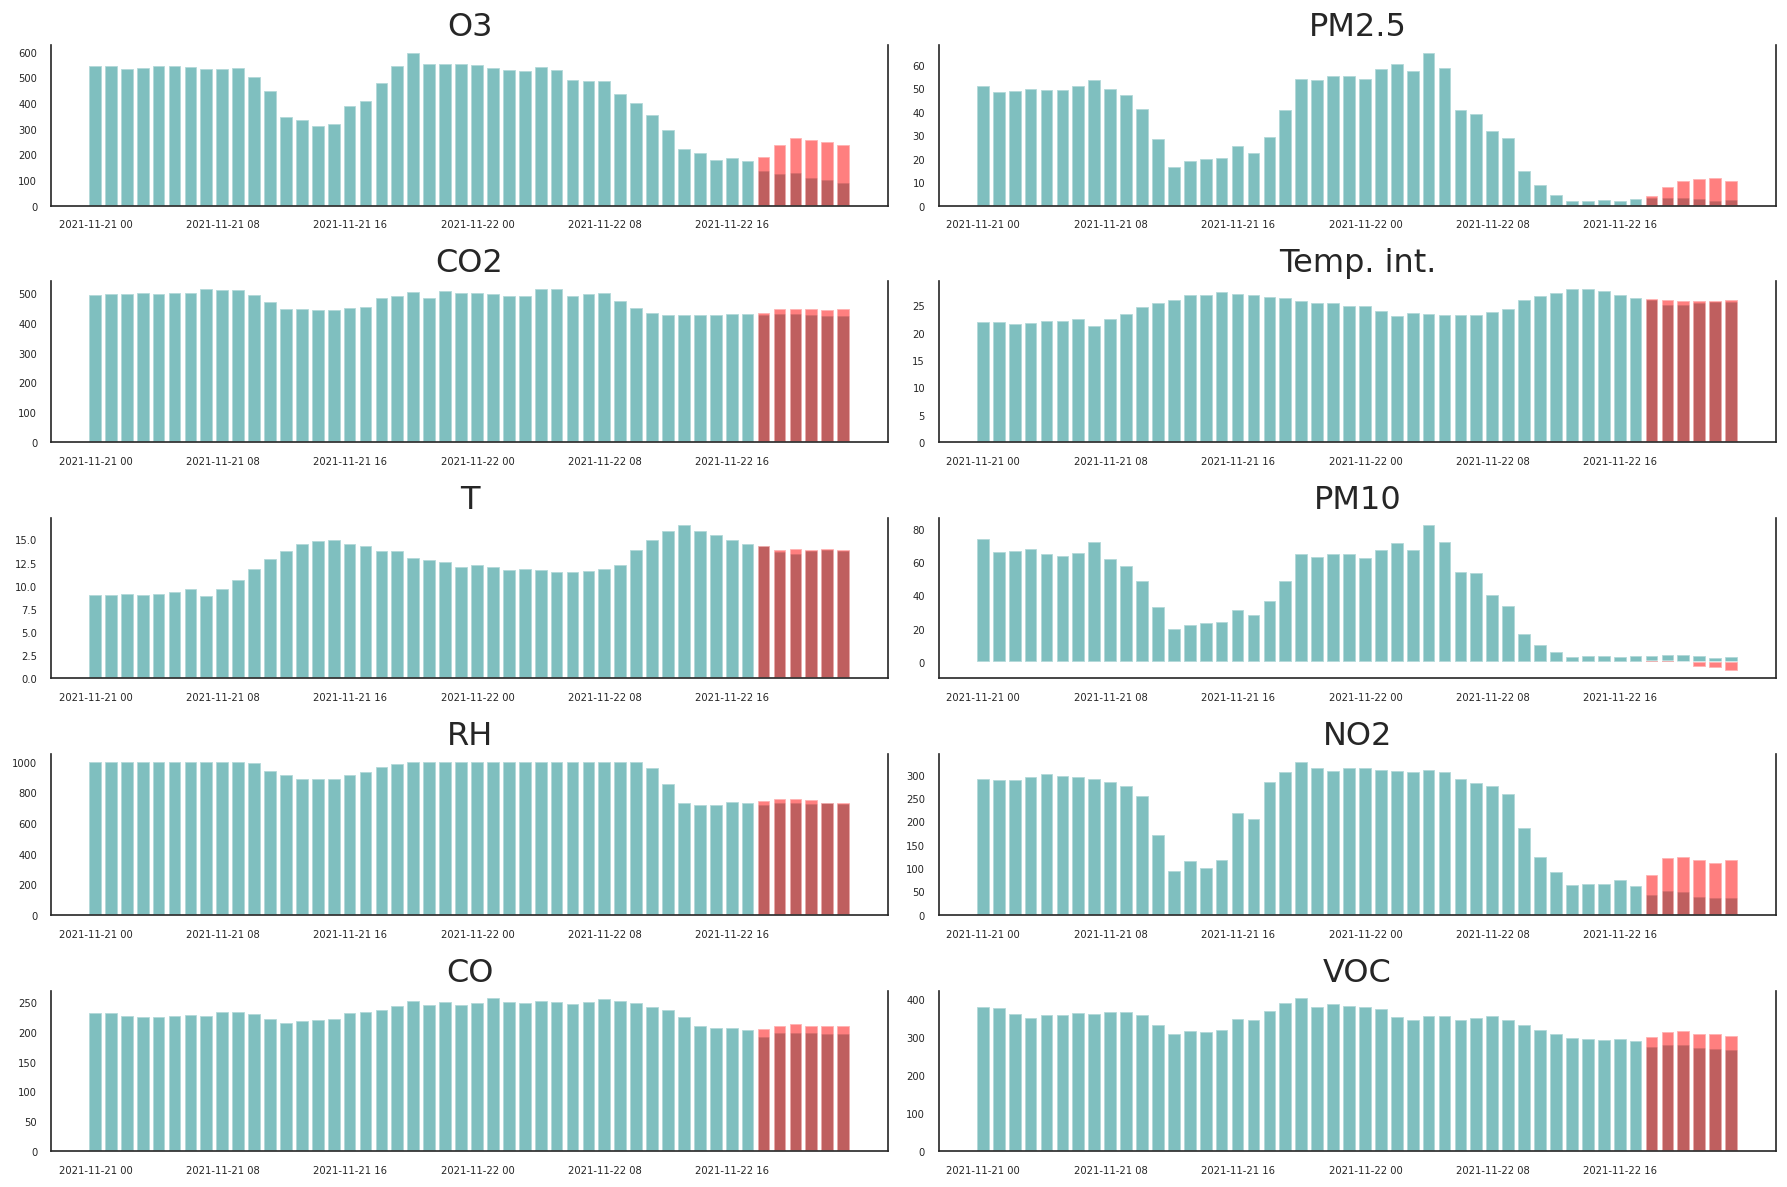

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if(len(df_train.columns)==10):
  num_row=5
else:
  num_row=6
x_ticks = np.arange(0, to_predict, 8)
# Plot
fig, axes = plt.subplots(nrows=num_row, ncols=2, dpi=120, figsize=(15,10))
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
  if(i<len(df_train.columns)):
    data_for = df_test[df_test.columns[i]]
    data_res_fc=res_fc[res_fc.columns[i]]
    ax.bar(data_for.index, data_for, alpha=0.5,color='teal', linewidth=1)
    ax.bar(data_res_fc.index, data_res_fc, alpha=0.5,color='red', linewidth=1)
    for j in range(len(for_index)):
      ax.axvline(for_index[j]	, color='black')
    # Decorations
    ax.set_title(df_copy.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.set_xticks(x_ticks)

plt.tight_layout();

Forecast accuracy:

In [ ]:
from statsmodels.tsa.stattools import acf
def adjust(val, length= 6): return str(val).ljust(length)

def forecast_accuracy(forecast, actual):
    if(all (np.abs(actual))!=0):
      mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
      mpe = np.mean((forecast - actual)/actual)   # MPE
    else: 
    #10 significa che non è calcolabile perchè actual è nullo
      mape=10
      mpe=10
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    #mette forecast e actual in 2 colonne parallele (hstack) e trova il minimo/massimo per ogni riga tra le 2 colonne
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    if(all (maxs)!=0):
      minmax = 1 - np.mean(mins/maxs)             # minmax
    else: 
      minmax=10
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,  'minmax':minmax})
for col in df_copy.columns:
  print('Forecast Accuracy of: '+col)
  accuracy_prod = forecast_accuracy(res_fc[col].values, df_test[col])
  for k, v in accuracy_prod.items():
     print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: O3
mape   :  0.4226
me     :  32.8442
mae    :  116.7588
mpe    :  0.2646
rmse   :  145.9244
minmax :  0.2577
Forecast Accuracy of: PM2.5
mape   :  1.6568
me     :  8.6841
mae    :  15.5114
mpe    :  1.5304
rmse   :  19.6219
minmax :  0.415
Forecast Accuracy of: CO2
mape   :  0.0452
me     :  5.7866
mae    :  20.9873
mpe    :  0.0148
rmse   :  26.9992
minmax :  0.0433
Forecast Accuracy of: Temp. int.
mape   :  0.0743
me     :  -1.093
mae    :  1.7549
mpe    :  -0.0463
rmse   :  2.8912
minmax :  0.0734
Forecast Accuracy of: T
mape   :  0.1761
me     :  -1.2303
mae    :  1.8708
mpe    :  -0.1178
rmse   :  3.1086
minmax :  0.1723
Forecast Accuracy of: PM10
mape   :  1.5138
me     :  31.8653
mae    :  46.0303
mpe    :  0.4897
rmse   :  82.2202
minmax :  0.8011
Forecast Accuracy of: RH
mape   :  0.1047
me     :  50.4964
mae    :  91.7283
mpe    :  0.061
rmse   :  142.5028
minmax :  0.086
Forecast Accuracy of: NO2
mape   :  0.7001
me     :  16.0915
mae    :  87.1075
mpe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


# Diving the wind in 3 different categories and using them to create 3 different forecasts

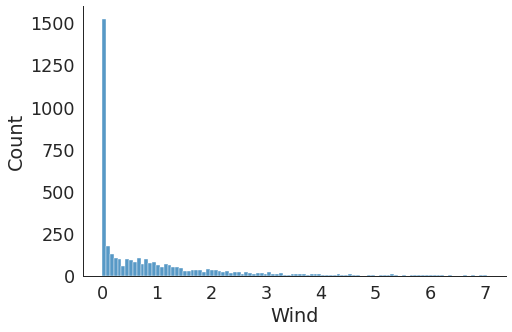

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

df_c=df_copy.copy()
df_train_inputs_w=df_copy.copy()

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_c, x='Wind', kind="hist", bins = 100, aspect = 1.5)

The wind values are diveded in categories: no wind, weak and strong wind.
Weak wind values are between 0 and threshold_wind, strong wind values are greater than threshold_wind

In [ ]:
threshold_wind=1

Count how many values would go in each category to find a good threshold

In [ ]:
cnt_w=0
cnt_s=0
cnt_n=0
for i in range(len(df_c)):
  if df_c['Wind'].iloc[i]==0:
    cnt_n+=1
  elif df_c['Wind'].iloc[i]<threshold_wind:
    cnt_w+=1
  else:
    cnt_s+=1
print(cnt_n)
print(cnt_w)
print(cnt_s)

1296
1471
1070


Create 3 tables (1 for each type of wind)

In [ ]:
df_c_n=df_c[(df_c['Wind'] ==0)]
df_c_temp=df_c[(df_c['Wind'] > 0 )]
df_c_w=df_c_temp[(df_c_temp['Wind'] < threshold_wind)]
df_c_s=df_c[(df_c['Wind'] >= threshold_wind)]
display(df_c_n)
display(df_c_w)
display(df_c_s)

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-07-03 23,369.512821,2.025641,406.051282,38.805641,25.271795,5.307692,556.282051,186.000000,238.820513,346.230769,0
2021-07-04 00,352.750000,2.000000,406.500000,37.901000,24.390000,5.450000,601.550000,185.450000,235.725000,340.900000,0
2021-07-04 01,349.000000,2.000000,408.692308,37.572308,23.946154,5.384615,633.538462,189.538462,236.282051,338.897436,0
2021-07-04 02,352.775000,2.050000,408.875000,37.329750,23.580000,5.400000,656.225000,179.025000,238.425000,337.000000,0
2021-07-04 03,328.923077,2.179487,411.410256,36.363077,22.653846,5.307692,690.102564,157.794872,237.282051,329.102564,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-08 07,511.000000,22.250000,507.775000,20.477500,8.792500,28.950000,999.000000,268.400000,237.925000,368.825000,0
2021-11-08 08,585.184211,22.526316,526.078947,22.086053,10.778947,27.947368,999.000000,287.473684,259.184211,399.421053,0
2021-11-08 09,576.475000,9.825000,512.325000,26.028750,14.235000,14.650000,951.550000,287.925000,257.950000,391.425000,0
2021-11-08 10,493.487179,7.205128,466.794872,28.771026,16.879487,12.128205,859.000000,253.461538,245.410256,362.102564,0


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-06-29 22,448.617647,1.058824,407.794118,43.116471,28.617647,5.264706,428.500000,236.323529,219.617647,381.264706,0.825
2021-06-29 23,429.605263,1.078947,408.763158,41.807895,27.131579,4.763158,492.763158,244.684211,225.078947,372.184211,0.425
2021-06-30 00,420.885714,1.200000,407.714286,40.208286,25.908571,4.285714,560.600000,255.971429,228.400000,358.800000,0.95
2021-06-30 01,417.868421,1.736842,408.368421,40.149211,25.263158,7.263158,623.842105,238.894737,231.710526,352.447368,0.675
2021-06-30 02,422.000000,1.918919,409.027027,39.953784,24.848649,6.972973,634.945946,253.081081,231.918919,354.891892,0.825
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-09 16,114.512821,1.282051,425.076923,18.729231,6.561538,2.128205,751.717949,37.461538,221.307692,276.794872,0.975
2021-12-09 20,254.692308,5.435897,436.794872,17.259487,5.133333,7.564103,829.256410,102.820513,195.384615,287.307692,0.7
2021-12-09 21,230.410256,7.076923,441.487179,16.334872,4.346154,9.410256,893.076923,144.025641,187.102564,292.538462,0.7
2021-12-09 22,385.350000,17.600000,454.075000,15.441000,3.590000,22.600000,964.500000,225.775000,203.675000,326.450000,0.775


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-06-29 12,473.000000,2.000000,413.500000,40.512500,28.200000,9.500000,497.250000,302.250000,225.750000,363.500000,1.725
2021-06-29 13,455.043478,1.173913,409.956522,43.817391,29.895652,5.434783,387.956522,233.869565,215.043478,377.565217,2.2
2021-06-29 14,463.750000,1.200000,407.350000,44.951500,31.090000,5.700000,371.850000,210.900000,217.250000,382.850000,2.075
2021-06-29 15,484.451613,1.000000,409.419355,45.840968,31.825806,6.129032,356.774194,225.322581,217.000000,392.161290,2.85
2021-06-29 16,512.931034,1.000000,410.206897,46.758276,32.686207,6.448276,350.862069,246.000000,219.655172,406.137931,3.2
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-09 14,202.871795,4.230769,433.948718,19.471026,7.389744,5.410256,888.615385,92.358974,220.179487,292.641026,1.025
2021-12-09 15,133.200000,0.900000,423.425000,19.063250,7.045000,1.325000,754.500000,34.775000,204.875000,264.300000,1.725
2021-12-09 17,106.925000,1.350000,425.625000,18.181500,6.572500,1.725000,741.325000,36.775000,220.775000,279.375000,1.3
2021-12-09 18,131.743590,1.974359,430.897436,17.840000,5.692308,2.974359,755.230769,55.256410,186.512821,272.051282,1.5


Create 3 different forecast models and use them

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results_n= {
    col: test_stationarity(df_c_n, col)
    for col in df_c_n.columns
}
display(adf_test_results_n)    

adf_test_results_w = {
    col: test_stationarity(df_c_w, col)
    for col in df_c_w.columns
}
display(adf_test_results_w)

adf_test_results_s = {
    col: test_stationarity(df_c_s, col)
    for col in df_c_s.columns
}
display(adf_test_results_s)  

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in double_scalars
  return self.params / self.bse
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary',
 'Wind': 'Non-Stationary'}

{'CO': 'Stationary',
 'CO2': 'Non-Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary',
 'Wind': 'Non-Stationary'}

{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Non-Stationary',
 'O3': 'Non-Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Non-Stationary',
 'Wind': 'Stationary'}

Use the differencing only on the variables that need it 

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
#no wind
for col in ['T', 'Temp. int.', 'NO2', 'O3','VOC','CO2', 'Wind']:
    df_c_n[col] = differencing(df_c_n, col, 1)
#weak wind
for col in['T', 'Temp. int.', 'NO2', 'O3','VOC','CO2', 'Wind']:
    df_c_w[col] = differencing(df_c_w, col, 1)
#strong wind
for col in ['T', 'Temp. int.', 'NO2', 'O3','VOC','CO2', 'Wind']:
    df_c_s[col] = differencing(df_c_s, col, 1)
#inputs
for col in ['T', 'Temp. int.', 'NO2', 'O3','VOC','CO2', 'Wind']:
    df_train_inputs_w[col] = differencing(df_train_inputs_w, col, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Find the best lag and create the models

In [ ]:
from statsmodels.tsa.api import VAR

max_lag=40

df_c_n=df_c_n.drop('Wind', axis=1)
model_n = VAR(df_c_n.astype(float))
lag_results_n = model_n.select_order(max_lag)
selected_lag_n = lag_results_n.aic
print('selected lag for the null: '+str(selected_lag_n))
model_fitted_n = model_n.fit(selected_lag_n)
var_summaryn=str(model_fitted_n.summary())
print(var_summaryn[0:624])

model_w = VAR(df_c_w.astype(float))
lag_results_w = model_w.select_order(max_lag)
selected_lag_w = lag_results_w.aic
print('selected lag for the weak: '+str(selected_lag_w))
model_fitted_w = model_w.fit(selected_lag_w)
var_summaryw=str(model_fitted_w.summary())
print(var_summaryw[0:624])

model_s = VAR(df_c_s.astype(float))
lag_results_s = model_s.select_order(max_lag)
selected_lag_s = lag_results_s.aic
print('selected lag for the strong: '+str(selected_lag_s))
model_fitted_s = model_s.fit(selected_lag_s)
var_summarys=str(model_fitted_s.summary())
print(var_summarys[0:624])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


selected lag for the null: 5
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jan, 2022
Time:                     09:39:53
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    40.7587
Nobs:                     1291.00    HQIC:                   39.4845
Log likelihood:          -42801.6    FPE:                6.54064e+16
AIC:                      38.7190    Det(Omega_mle):     4.43974e+16
--------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


selected lag for the weak: 8
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jan, 2022
Time:                     09:39:56
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    43.2988
Nobs:                     1463.00    HQIC:                   41.0800
Log likelihood:          -50940.5    FPE:                1.85483e+17
AIC:                      39.7601    Det(Omega_mle):     9.68686e+16
--------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


selected lag for the strong: 5
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jan, 2022
Time:                     09:39:58
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    42.4860
Nobs:                     1065.00    HQIC:                   40.7003
Log likelihood:          -37099.7    FPE:                1.59687e+17
AIC:                      39.6109    Det(Omega_mle):     9.08768e+16
--------------------------------------------------------------------



Predicting "to_predict_w" values using "forecast_interval_w" in "times" steps.
Finding the median of every "step" to choose the correct model and forecast all values
to_predict_w should always be a multiple of forecast_interval_w

In [ ]:
to_predict_w=72
forecast_interval_w = 6
times= int(to_predict_w/forecast_interval_w)
res_fc=pd.DataFrame(index=df_copy.index[-to_predict_w:], columns=df_copy.columns)
allvalues=[]
df_inputs_no=df_train_inputs_w[-to_predict_w-selected_lag_n:-forecast_interval_w].copy()
df_inputs_weak=df_train_inputs_w[-to_predict_w-selected_lag_w:-forecast_interval_w].copy()
df_inputs_strong=df_train_inputs_w[-to_predict_w-selected_lag_s:-forecast_interval_w].copy()
for i in range(times):
  if(-to_predict_w+(i+1)*forecast_interval_w==0):
    temp=df_c.iloc[-forecast_interval_w:]
    forecast_input_no= df_inputs_no.iloc[-selected_lag_n:].values
    forecast_input_weak= df_inputs_weak.iloc[-selected_lag_w:].values
    forecast_input_strong= df_inputs_strong.iloc[-selected_lag_s:].values
  else:
    temp=df_c.iloc[-to_predict_w+i*forecast_interval_w:-to_predict_w+(i+1)*forecast_interval_w]
    forecast_input_no= df_inputs_no.iloc[(i)*forecast_interval_w:(i)*forecast_interval_w+selected_lag_n].values
    forecast_input_weak= df_inputs_weak.iloc[(i)*forecast_interval_w:(i)*forecast_interval_w+selected_lag_w].values
    forecast_input_strong= df_inputs_strong.iloc[(i)*forecast_interval_w:(i)*forecast_interval_w+selected_lag_s].values
  if temp['Wind'].median() <= 0.15:
    print(str(i)+' no wind')
    fc = model_fitted_n.forecast(y=forecast_input_no, steps=forecast_interval_w)
  if temp['Wind'].median() <1 and temp['Wind'].median()>0.15:
    print(str(i)+' weak wind')
    fc = model_fitted_w.forecast(y=forecast_input_weak, steps=forecast_interval_w)
  if temp['Wind'].median()>=1:
    print(str(i)+' strong wind')
    fc = model_fitted_s.forecast(y=forecast_input_strong, steps=forecast_interval_w)
  if(-to_predict_w+(i+1)*forecast_interval_w==0):
    temp_res = pd.DataFrame(fc, index=df_copy.index[-forecast_interval_w:], columns=df_copy.columns)
    diff= pd.DataFrame( index=df_copy.index[-forecast_interval_w-1:], columns=['T', 'Temp. int.', 'NO2', 'O3','VOC','CO2'])
  else:
    temp_res = pd.DataFrame(fc, index=df_copy.index[-to_predict_w+i*forecast_interval_w:-to_predict_w+(i+1)*forecast_interval_w], columns=df_copy.columns)
    diff = pd.DataFrame(index=df_copy.index[-to_predict_w+i*forecast_interval_w-1:-to_predict_w+(i+1)*forecast_interval_w], columns=['T', 'Temp. int.', 'NO2', 'O3','VOC','CO2'])
  for col in ['T', 'Temp. int.', 'NO2', 'O3','VOC','CO2']:
    x, x_diff = df_copy[col].iloc[-to_predict_w+i*forecast_interval_w-1:-to_predict_w+i*forecast_interval_w], temp_res[col]
    diff[col] = np.r_[x, x_diff].cumsum()
  #dopo il revert differencing i valori sono 7, non 6
  diff=diff.iloc[-forecast_interval_w:]
  for col in ['T', 'Temp. int.', 'NO2', 'O3','VOC','CO2']:
    temp_res[col]=diff[col]
  res_fc.iloc[i*forecast_interval_w:(i+1)*forecast_interval_w]=temp_res
display(res_fc)

0 weak wind
1 weak wind
2 weak wind
3 strong wind
4 weak wind
5 weak wind
6 strong wind
7 weak wind
8 weak wind
9 weak wind
10 strong wind
11 weak wind


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-12-07 00,507.417,26.7631,480.585,12.0907,0.772035,37.8963,846.198,260.383,212.921,373.754,0.102173
2021-12-07 01,491.369,24.1073,484.302,13.2083,1.81687,43.5131,833.066,256.372,208.02,365.093,-0.0823722
2021-12-07 02,443.721,21.0598,479.014,14.1909,2.78543,43.2023,808.047,228.401,205.806,351.089,0.0515921
2021-12-07 03,453.468,27.0738,483.788,14.1884,2.78001,50.9041,812.874,237.508,207.831,356.561,-0.014072
2021-12-07 04,450.18,20.4042,482.345,14.2086,2.77563,30.1732,828.045,240.931,209.551,356.685,0.00936521
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-09 19,187.958,9.39506,437.365,17.3351,5.46755,8.76362,799.24,74.7505,218.431,295.635,0.124579
2021-12-09 20,183.204,8.85566,433.32,18.2644,6.37995,8.45072,765.924,65.469,216.784,294.967,-0.0181096
2021-12-09 21,197.9,9.72474,432.393,19.0173,7.08691,10.3069,752.04,64.5149,214.864,298.097,-0.0724583
2021-12-09 22,195.518,9.49265,431.087,19.8207,7.79863,15.7597,723.197,53.9498,212.181,296.765,-0.0299264


In [ ]:
fc_index=res_fc.index
for_index=[]
for i in range(len(fc_index)):
  if(i%forecast_interval_w==0):
    for_index.append(fc_index[i])

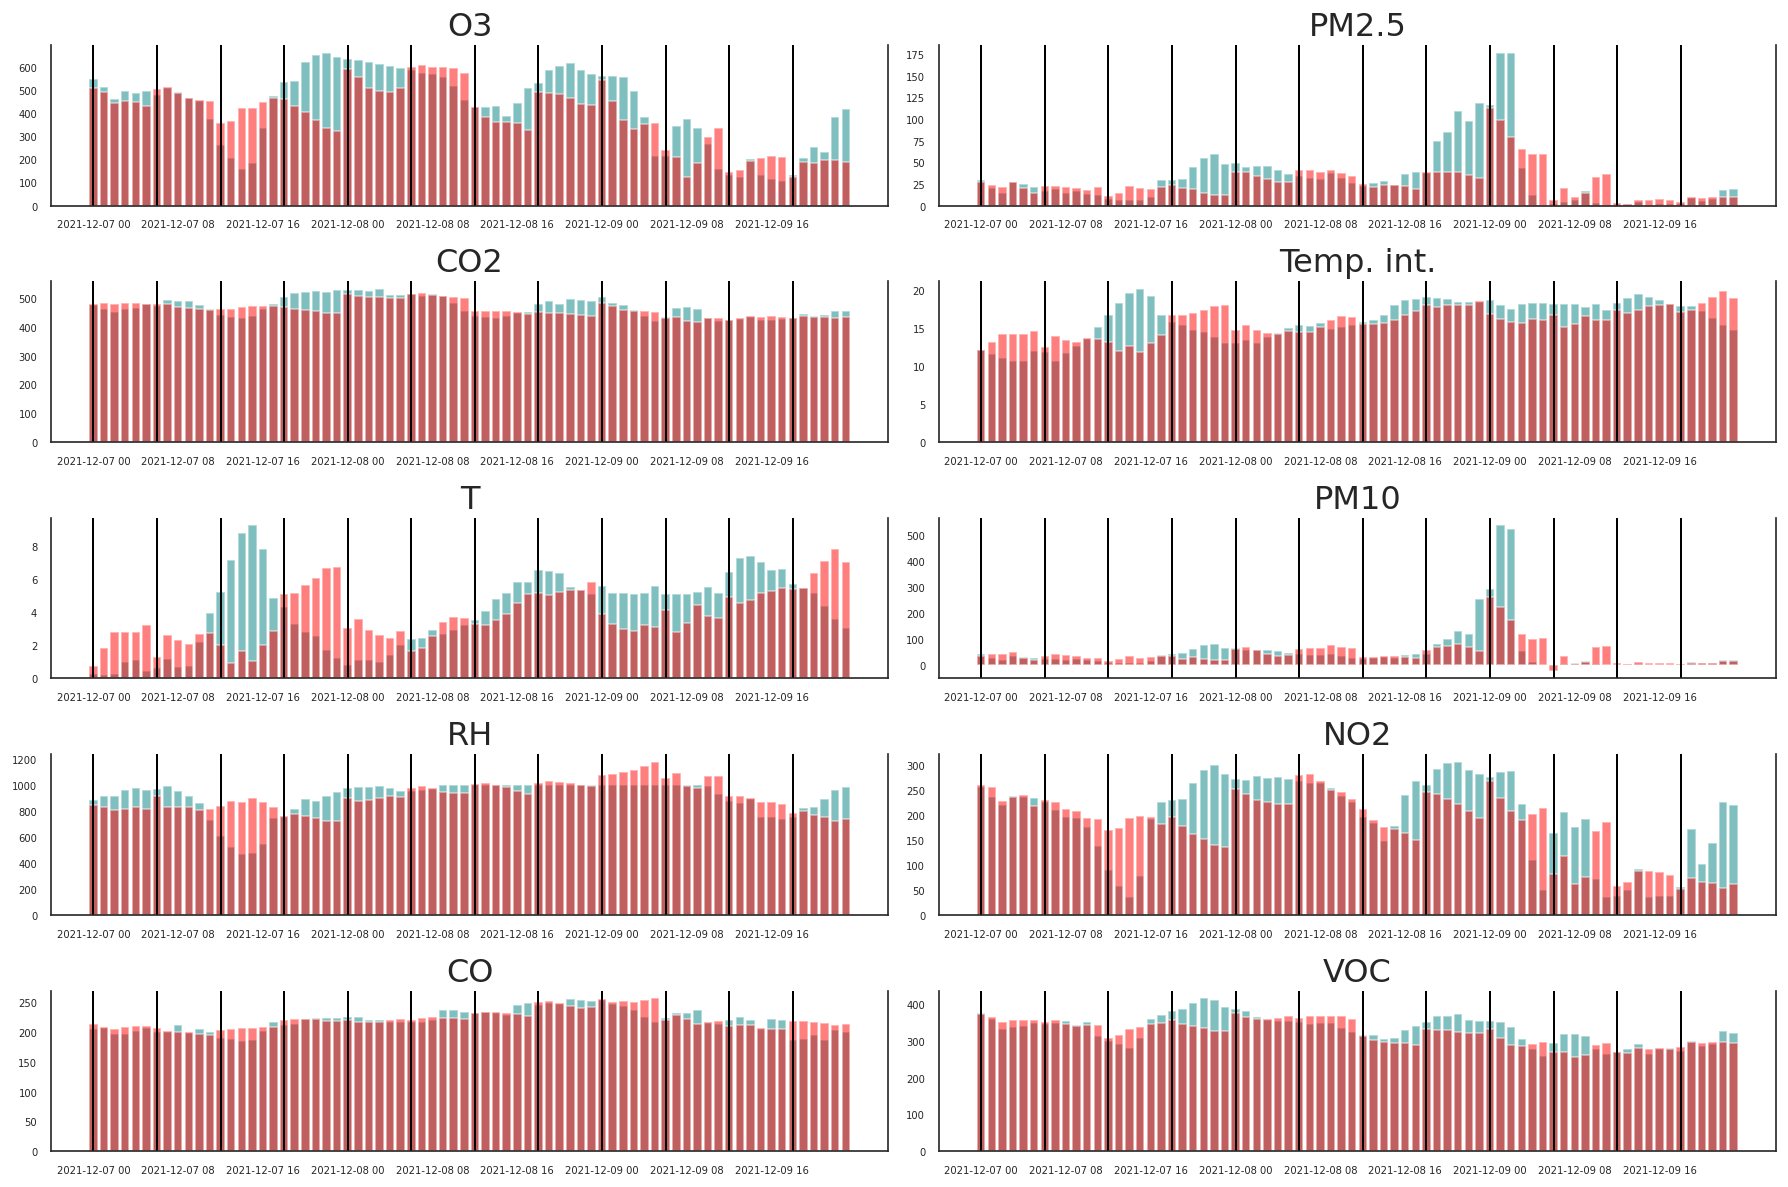

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x_ticks = np.arange(0, to_predict_w, 8)
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(15,10))
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
  data_for_w = df_c[df_c.columns[i]].iloc[-to_predict_w:]
  data_res_fc=res_fc[res_fc.columns[i]]
  ax.bar(data_for_w.index, data_for_w, alpha=0.5,color='teal', linewidth=1)
  ax.bar(data_res_fc.index, data_res_fc, alpha=0.5,color='red', linewidth=1)
  for j in range(len(for_index)):
    ax.axvline(for_index[j]	, color='black')
  # Decorations
  ax.set_title(df_copy.columns[i])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  ax.spines["top"].set_alpha(0)
  ax.tick_params(labelsize=6)
  ax.set_xticks(x_ticks)

plt.tight_layout();

Forecast accuracy:

In [ ]:
from statsmodels.tsa.stattools import acf
def adjust(val, length= 6): return str(val).ljust(length)

def forecast_accuracy(forecast, actual):
    if(all (np.abs(actual))!=0):
      mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
      mpe = np.mean((forecast - actual)/actual)   # MPE
    else: 
    #10 significa che non è calcolabile perchè actual è nullo
      mape=10
      mpe=10
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    #mette forecast e actual in 2 colonne parallele (hstack) e trova il minimo/massimo per ogni riga tra le 2 colonne
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    if(all (maxs)!=0):
      minmax = 1 - np.mean(mins/maxs)             # minmax
    else: 
      minmax=10
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,  'minmax':minmax})
for col in df_copy.columns:
  print('Forecast Accuracy of: '+col)
  accuracy_prod = forecast_accuracy(res_fc[col].values, df_c[col].iloc[-to_predict_w:])
  for k, v in accuracy_prod.items():
     print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: O3
mape   :  0.2747
me     :  -39.4767
mae    :  94.6338
mpe    :  0.0045
rmse   :  124.3337
minmax :  0.2134
Forecast Accuracy of: PM2.5
mape   :  2.8338
me     :  -5.6499
mae    :  16.4033
mpe    :  2.4957
rmse   :  27.0639
minmax :  0.4
Forecast Accuracy of: CO2
mape   :  0.0458
me     :  -8.0505
mae    :  21.8791
mpe    :  -0.0145
rmse   :  28.6465
minmax :  0.045
Forecast Accuracy of: Temp. int.
mape   :  0.1251
me     :  -0.3133
mae    :  1.9575
mpe    :  0.0009
rmse   :  2.5662
minmax :  0.1134
Forecast Accuracy of: T
mape   :  1.0305
me     :  -0.2364
mae    :  1.9301
mpe    :  0.6745
rmse   :  2.5129
minmax :  0.4017
Forecast Accuracy of: PM10
mape   :  3.1263
me     :  -6.5358
mae    :  32.1175
mpe    :  2.565
rmse   :  66.8544
minmax :  0.5614
Forecast Accuracy of: RH
mape   :  0.1261
me     :  2.7116
mae    :  97.6009
mpe    :  0.0259
rmse   :  133.184
minmax :  0.1038
Forecast Accuracy of: NO2
mape   :  0.5045
me     :  -17.4278
mae    :  56.7905
mpe 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
